### TIỀN XỬ LÝ DỮ LIỆU

1. Khởi tạo và import thư viện

Import các thư viện cần thiết

In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


# Import các thư viện Machine Learning
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from prophet import Prophet
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Tắt cảnh báo không cần thiết
import warnings
warnings.filterwarnings("ignore")

Tải lên file .csv chứa dữ liệu bán hàng

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Hydraulic_Sales_Cleaned.csv to Hydraulic_Sales_Cleaned.csv


Đọc file .csv vừa tải lên

In [ ]:
df = pd.read_csv('Hydraulic_Sales_Cleaned.csv')
df.head()

date product_type product_code     variant region  country  \
0  2020-01     DC Valve      DCV-315  2-position  North  Germany   
1  2020-01     DC Valve      DCV-315  2-position  North      USA   
2  2020-01     DC Valve      DCV-315  2-position  North      USA   
3  2020-01     DC Valve      DCV-315  2-position  North      USA   
4  2020-01     DC Valve      DCV-315  2-position  North      USA   

  customer_segment  channel application_area  units_sold  ...  \
0              OEM   Direct      Agriculture          50  ...   
1              OEM  Offline     Construction         189  ...   
2              OEM   Direct           Mining         149  ...   
3              OEM   Direct      Agriculture          86  ...   
4              OEM   Dealer       Industrial         184  ...   

   competitor_activity  seasonality_index  economic_indicator  \
0                    3               1.06                7.90   
1                    5               0.93                7.92   
2                    0               1.05                6.79   
3                    6               1.10                7.60   
4                    2               0.89                6.86   

   new_product_launch  failure_rate_pct  return_units  pressure_rating_bar  \
0                   0              0.56             0                  350   
1                   0              2.28             2                  250   
2                   0              1.97             4                  160   
3                   0              1.06             4                  350   
4                   0              0.17             2                  200   

   temperature_rating_c  oil_type  unit_price  
0                   110     HLP46      6000.0  
1                    90     HLP46      6000.0  
2                    80    HVLP46      6000.0  
3                   110     HLP46      6000.0  
4                    90    HVLP68      6000.0  

[5 rows x 25 columns]

2. Kiểm tra dữ liệu

Kiểm tra cấu trúc dữ liệu

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228045 entries, 2020-01-01 to 2024-12-01
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   product_type          228045 non-null  object 
 1   product_code          228045 non-null  object 
 2   variant               228045 non-null  object 
 3   region                228045 non-null  object 
 4   country               228045 non-null  object 
 5   customer_segment      228045 non-null  object 
 6   channel               228045 non-null  object 
 7   application_area      228045 non-null  object 
 8   units_sold            228045 non-null  int64  
 9   revenue               228045 non-null  float64
 10  marketing_spend       228045 non-null  int64  
 11  discount_percent      228045 non-null  int64  
 12  stock_available       228045 non-null  int64  
 13  lead_time_days        228045 non-null  int64  
 14  competitor_activity   228045 non-nul

Kiểm tra số lượng dòng bị trùng và số lượng dữ liệu thiếu.

In [ ]:
df.isna().sum()

product_type            0
product_code            0
variant                 0
region                  0
country                 0
customer_segment        0
channel                 0
application_area        0
units_sold              0
revenue                 0
marketing_spend         0
discount_percent        0
stock_available         0
lead_time_days          0
competitor_activity     0
seasonality_index       0
economic_indicator      0
new_product_launch      0
failure_rate_pct        0
return_units            0
pressure_rating_bar     0
temperature_rating_c    0
oil_type                0
unit_price              0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(0)

3. Xử lý dữ liệu và gom nhóm

In [ ]:
df['date'] = pd.to_datetime(df['date'])

# Định nghĩa quy tắc gom
agg_rules = {
    'units_sold': 'sum',          # Target
    'unit_price': 'mean',         # Exogenous var
    'stock_available': 'mean',    # Exogenous var
    'discount_percent': 'mean',   # Exogenous var
    'economic_indicator': 'mean', # Exogenous var
    'competitor_activity': 'mean',# Exogenous var
    'lead_time_days': 'mean'      # Exogenous var
}

# Tạo bảng tổng hợp (Master Table)
# KHÔNG CÓ VÒNG LẶP Ở ĐÂY, chỉ là groupby
df_master = df.groupby(['date', 'region', 'country']).agg(agg_rules).reset_index()
df_master = df_master.sort_values(['region', 'country', 'date'])

# Danh sách các yếu tố bên ngoài (Exogenous) bạn muốn đưa vào
exog_cols = ['unit_price', 'stock_available', 'discount_percent',
             'economic_indicator', 'competitor_activity', 'lead_time_days']

### KHÁM PHÁ DỮ LIỆU (EDA - Exploratory Data Analysis)

1. Thống kê dữ liệu

In [ ]:
df.describe()

units_sold       revenue  marketing_spend  discount_percent  \
count  228045.000000  2.280450e+05    228045.000000     228045.000000   
mean      193.030678  1.150673e+06     32638.893012          8.502598   
std        90.553313  5.428094e+05     31283.612199          3.459157   
min        50.000000  2.500000e+05     10000.000000          3.000000   
25%       123.000000  7.320000e+05     20054.000000          5.000000   
50%       175.000000  1.038000e+06     30205.000000          8.000000   
75%       248.000000  1.482000e+06     40266.000000         12.000000   
max       499.000000  2.994000e+06    499750.000000         14.000000   

       stock_available  lead_time_days  competitor_activity  \
count    228045.000000   228045.000000        228045.000000   
mean        299.343581       12.001829             4.504076   
std         115.383161        4.318727             2.869655   
min         100.000000        5.000000             0.000000   
25%         199.000000        8.000000             2.000000   
50%         300.000000       12.000000             5.000000   
75%         399.000000       16.000000             7.000000   
max         499.000000       19.000000             9.000000   

       seasonality_index  economic_indicator  new_product_launch  \
count      228045.000000       228045.000000       228045.000000   
mean            1.049908            7.000116            0.100542   
std             0.115472            0.865431            0.300721   
min             0.850000            5.500000            0.000000   
25%             0.950000            6.250000            0.000000   
50%             1.050000            7.000000            0.000000   
75%             1.150000            7.750000            0.000000   
max             1.250000            8.500000            1.000000   

       failure_rate_pct   return_units  pressure_rating_bar  \
count     228045.000000  228045.000000        228045.000000   
mean           1.298290       1.998588           255.122169   
std            0.693459       1.415335            70.319502   
min            0.100000       0.000000           160.000000   
25%            0.700000       1.000000           200.000000   
50%            1.300000       2.000000           250.000000   
75%            1.900000       3.000000           315.000000   
max            2.500000       4.000000           350.000000   

       temperature_rating_c     unit_price  
count         228045.000000  228045.000000  
mean              95.018527    5957.227740  
std               11.173934     202.343701  
min               80.000000    5000.000000  
25%               90.000000    6000.000000  
50%              100.000000    6000.000000  
75%              110.000000    6000.000000  
max              110.000000    6000.000000

In [ ]:
df.describe(include = 'object')

product_type product_code     variant  region country customer_segment  \
count        228045       228045      228045  228045  228045           228045   
unique            2            2           6       4       4                4   
top        DC Valve      DCV-315  4-position   South  Brazil              OEM   
freq         218182       218182       73560   57046   57037            57032   

        channel application_area oil_type  
count    228045           228045   228045  
unique        4                4        4  
top     Offline      Agriculture   HVLP46  
freq      57422            57192    57161

2. Phân tích đơn biến (UNIVARIATE ANALYSIS)

2.1. Với biến mục tiêu (units_sold)

=== Thống kê mô tả cho units_sold ===
count    228045.000000
mean        193.030678
std          90.553313
min          50.000000
25%         123.000000
50%         175.000000
75%         248.000000
max         499.000000
Name: units_sold, dtype: float64
Độ lệch (Skewness): 0.7927
Độ nhọn (Kurtosis): 0.1527


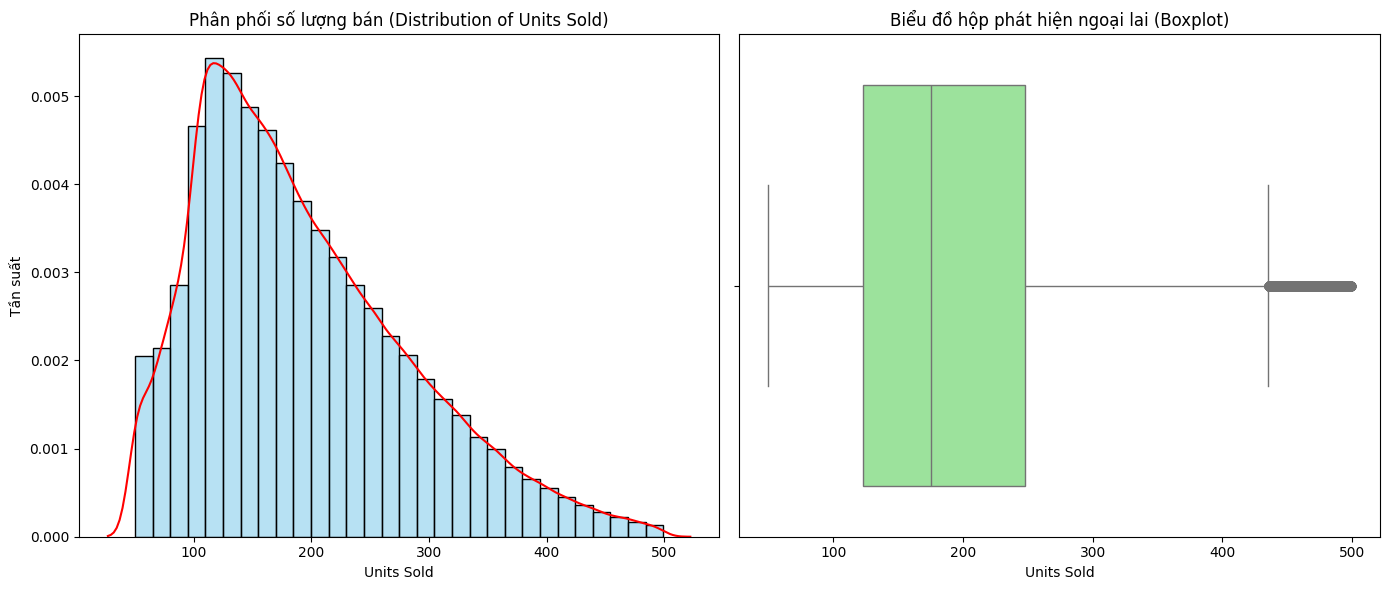

In [ ]:
# 2. Tính toán các chỉ số thống kê mô tả
target = df['units_sold']
desc_stats = target.describe()
skewness = target.skew()  # Độ lệch (Skewness)
kurtosis = target.kurt()  # Độ nhọn (Kurtosis)

print("=== Thống kê mô tả cho units_sold ===")
print(desc_stats)
print(f"Độ lệch (Skewness): {skewness:.4f}")
print(f"Độ nhọn (Kurtosis): {kurtosis:.4f}")

# 3. Vẽ biểu đồ trực quan hóa
plt.figure(figsize=(14, 6))

# Biểu đồ 1: Histogram kèm đường KDE (Kernel Density Estimate)
# Giúp bạn thấy hình dạng phân phối của dữ liệu
ax1 = plt.subplot(1, 2, 1)
sns.histplot(df['units_sold'], kde=False, stat="density",
             color="skyblue", alpha=0.6, bins=30, ax=ax1)
sns.kdeplot(df['units_sold'], color="red", ax=ax1)
plt.title('Phân phối số lượng bán (Distribution of Units Sold)')
plt.xlabel('Units Sold')
plt.ylabel('Tần suất')

# Biểu đồ 2: Boxplot
# Giúp bạn nhìn nhanh giá trị trung vị và các điểm ngoại lai (outliers)
plt.subplot(1, 2, 2)
sns.boxplot(x=target, color='lightgreen')
plt.title('Biểu đồ hộp phát hiện ngoại lai (Boxplot)')
plt.xlabel('Units Sold')

plt.tight_layout()
plt.show()



*   Phần lớn các đơn hàng tháng có doanh số nằm ở mức trung bình thấp (khoảng 100 - 250 sản phẩm), nhưng đuôi bên phải kéo dài cho thấy thỉnh thoảng có những đơn doanh số tăng vọt (lên tới 400-500).
*   Dùng các mô hình (XGBoost), độ lệch này có thể không ảnh hưởng quá nhiều nên em sẽ giữ nguyên dữ liệu gốc.
*   Một số đơn doanh số cao đột biến (trên 440 đơn vị). Đây có thể là các đợt khuyến mãi lớn hoặc sự kiện đặc biệt, chứ không hẳn là dữ liệu nhiễu (noise/error). Em sẽ giữ lại chúng vì chúng mang thông tin quan trọng cho việc dự báo các đợt cao điểm.





2.2. Với các yếu tố khác

2.2.1 Phân tích các biến số (NUMERICAL)

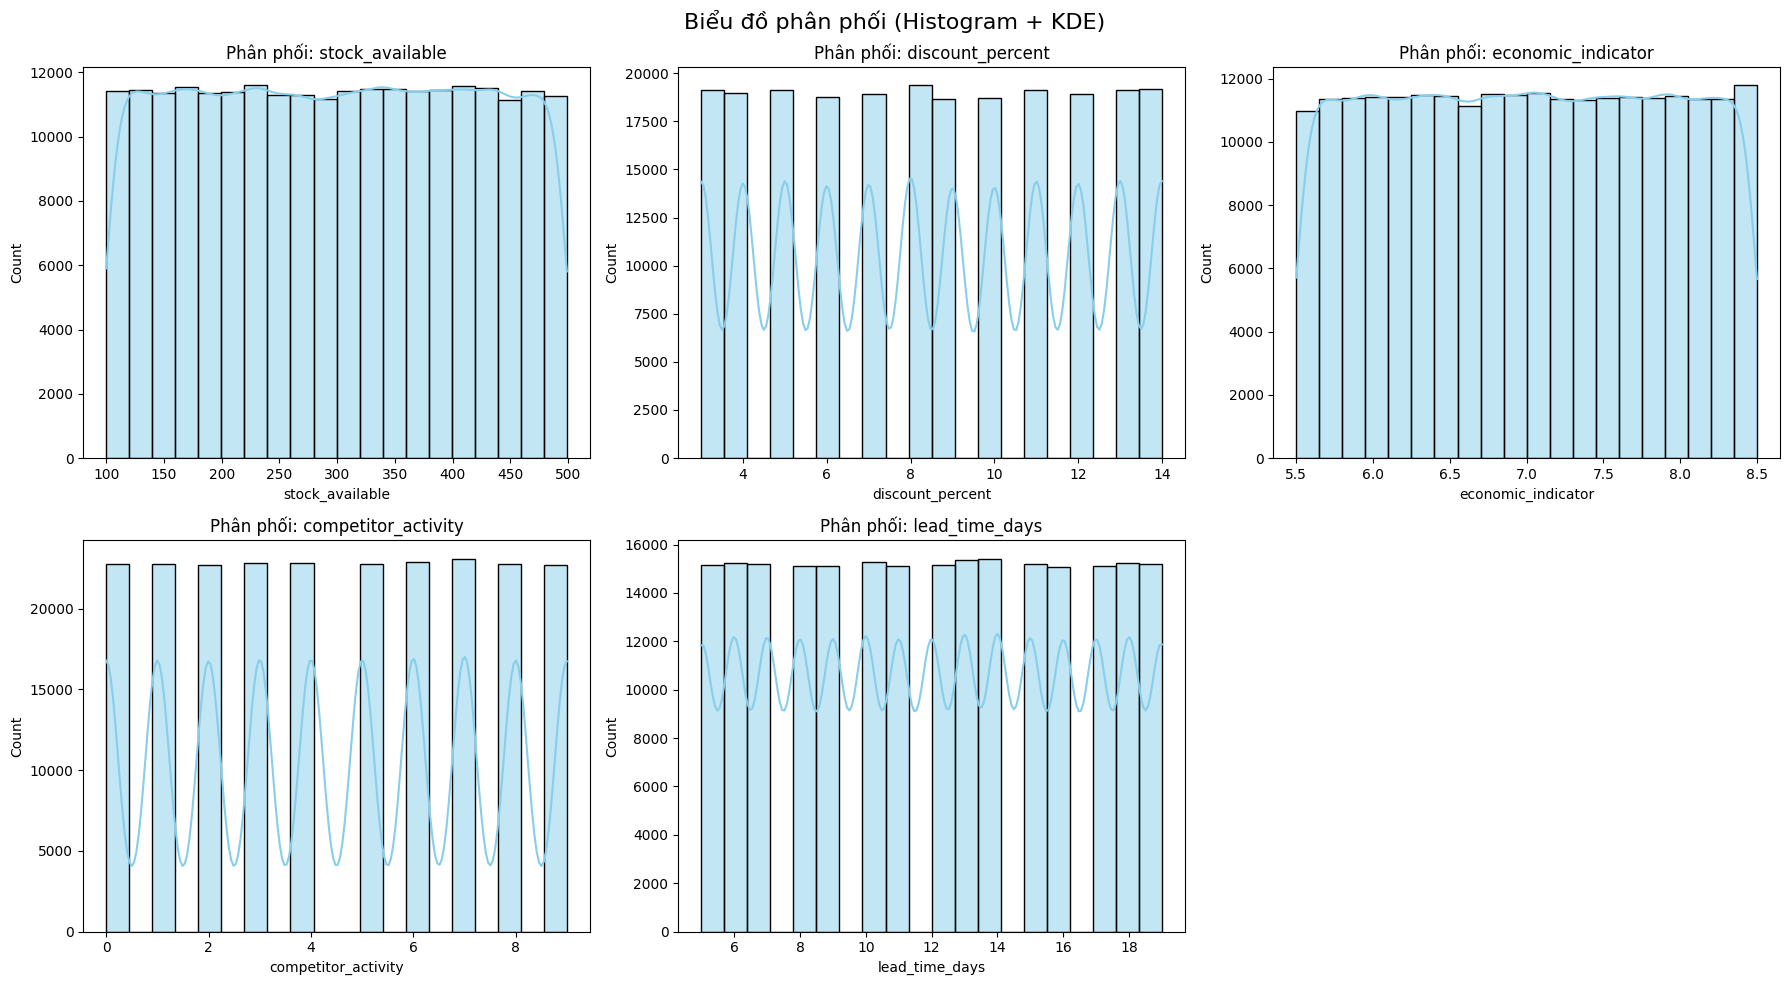

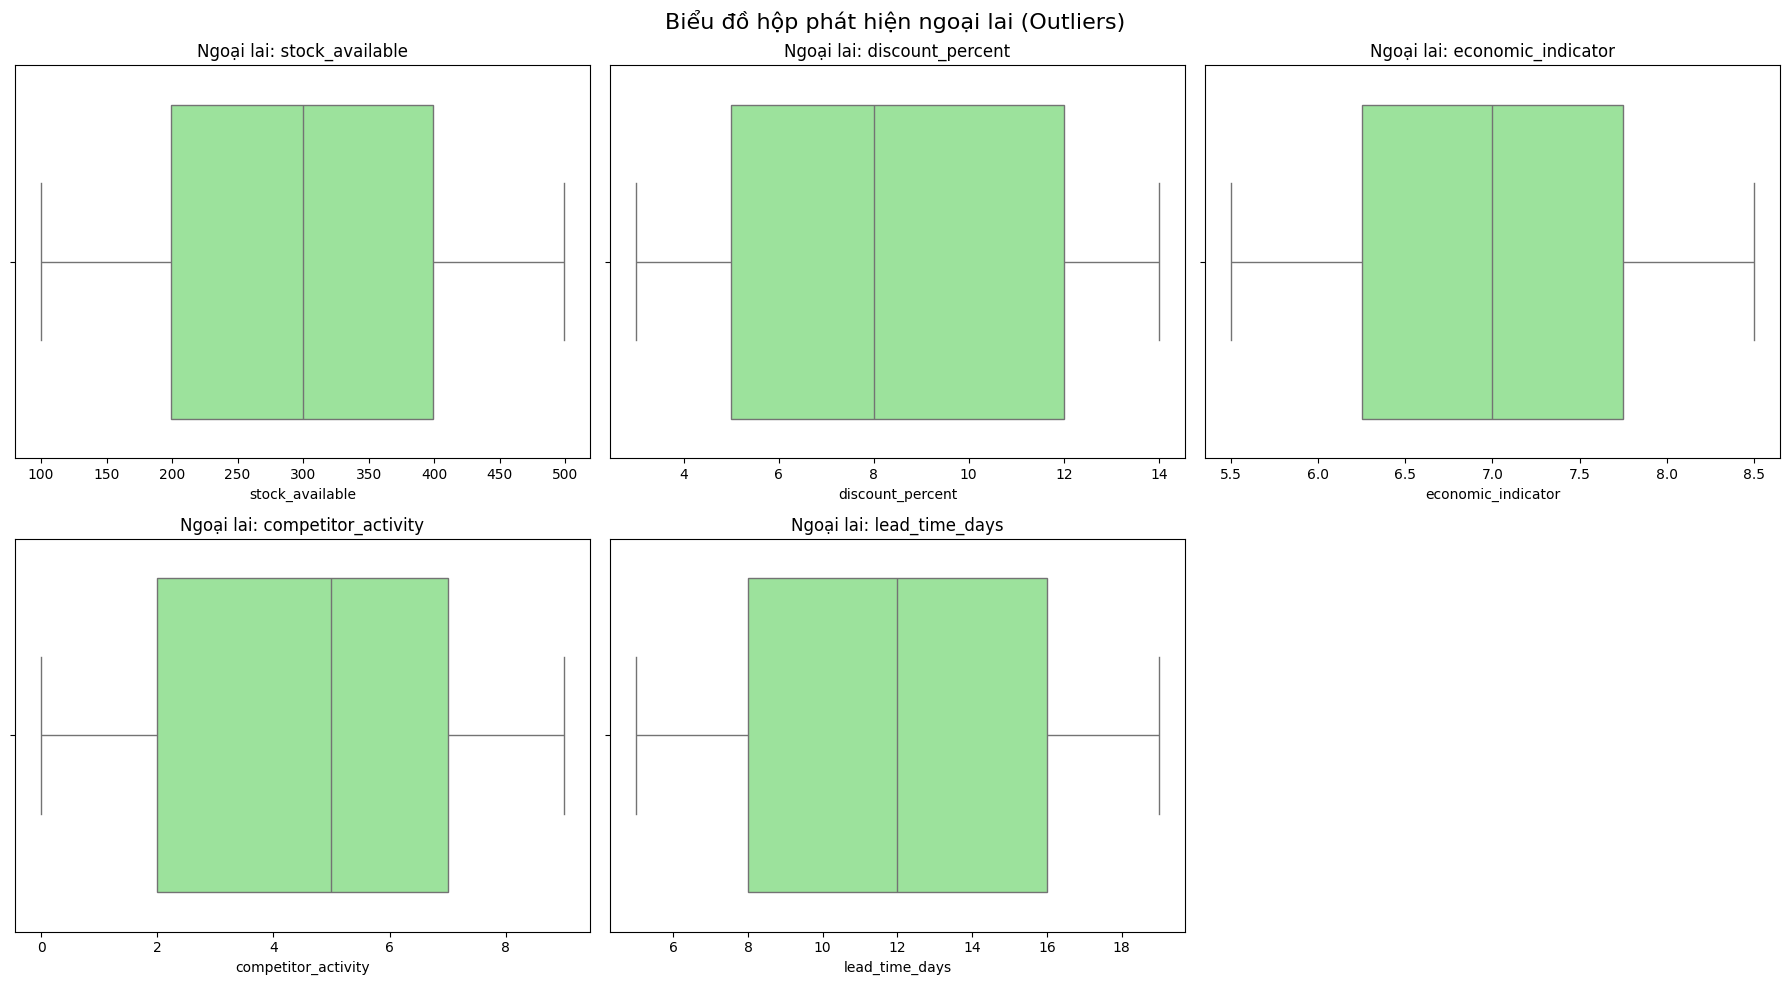

In [ ]:
   num_vars = ['stock_available', 'discount_percent',
            'economic_indicator', 'competitor_activity', 'lead_time_days']

# 1.1 Vẽ Lưới Histogram (Xem phân phối)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Biểu đồ phân phối (Histogram + KDE)', fontsize=16)

for i, var in enumerate(num_vars):
    row, col = i // 3, i % 3
    sns.histplot(df[var], kde=True, ax=axes[row, col], color='skyblue', bins=20)
    axes[row, col].set_title(f'Phân phối: {var}')
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# 1.2 Vẽ Lưới Boxplot (Xem ngoại lai)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Biểu đồ hộp phát hiện ngoại lai (Outliers)', fontsize=16)

for i, var in enumerate(num_vars):
    row, col = i // 3, i % 3
    sns.boxplot(x=df[var], ax=axes[row, col], color='lightgreen')
    axes[row, col].set_title(f'Ngoại lai: {var}')
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

2.2.2. Phân tích các biến phân loại (CATEGORICAL)

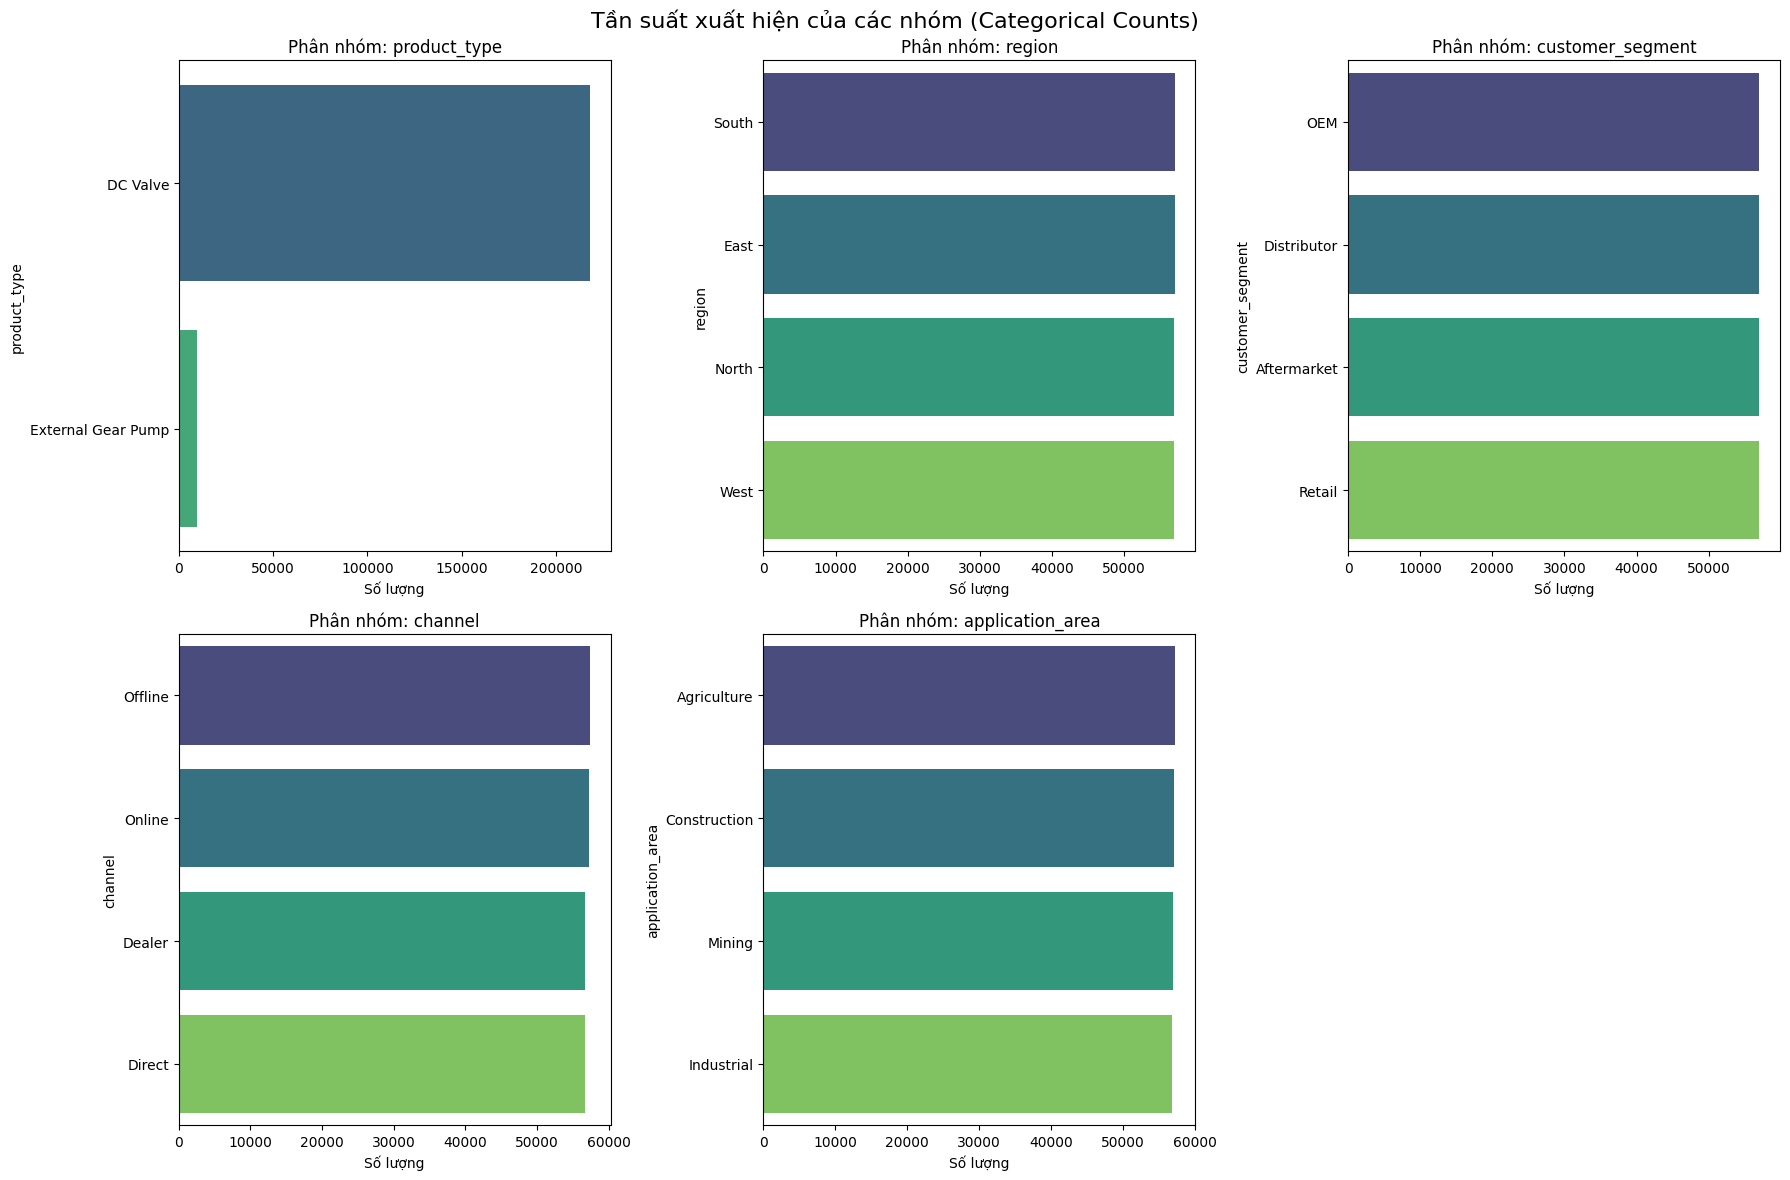

In [ ]:
# Các biến định danh quan trọng
cat_vars = ['product_type', 'region', 'customer_segment', 'channel', 'application_area']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Tần suất xuất hiện của các nhóm (Categorical Counts)', fontsize=16)

# Trải phẳng lưới đồ thị để dễ lặp
axes_flat = axes.flatten()

for i, var in enumerate(cat_vars):
    # Đếm số lượng và sắp xếp giảm dần để dễ nhìn
    order = df[var].value_counts().index
    sns.countplot(y=df[var], order=order, ax=axes_flat[i], palette='viridis')
    axes_flat[i].set_title(f'Phân nhóm: {var}')
    axes_flat[i].set_xlabel('Số lượng')

# Tắt khung đồ thị thừa (nếu có)
if len(cat_vars) < 6:
    axes_flat[-1].axis('off')

plt.tight_layout()
plt.show()

3. Phân tích hai biến (BIVARIATE ANALYSIS)

3.1. Quan hệ Khuyến mãi & Lượng (discount_percent vs units_sold)

Hệ số tương quan (Discount vs Sales): 0.5726


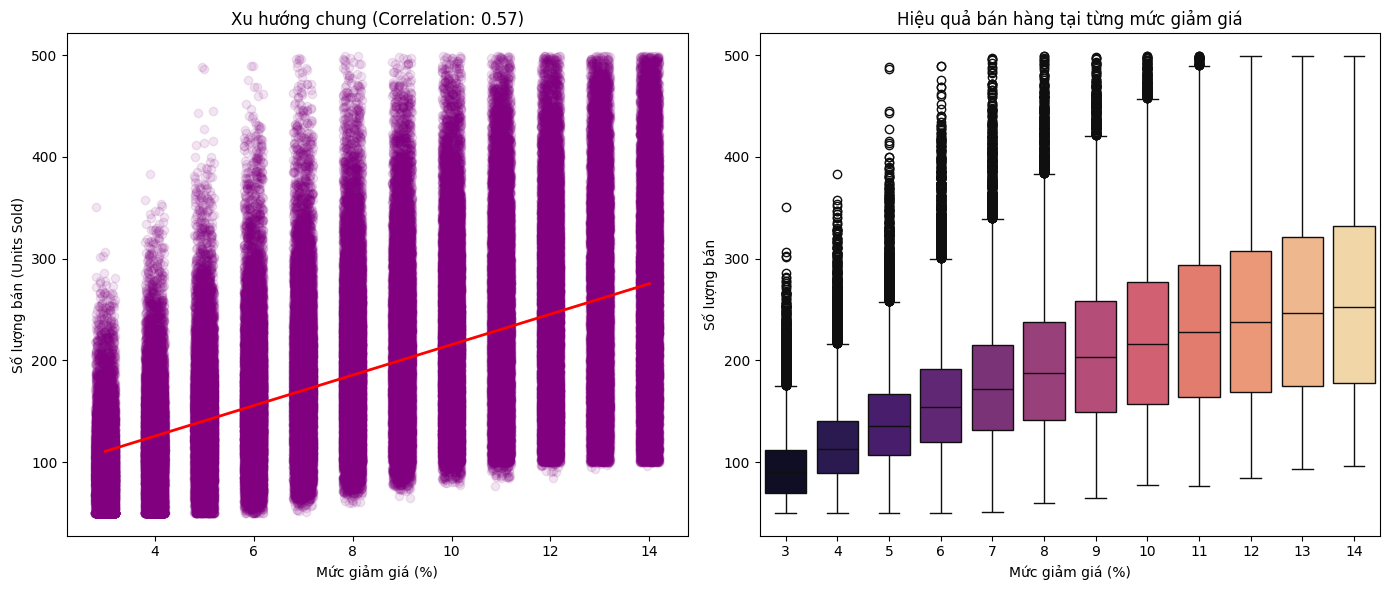

In [ ]:
# 2. Tính hệ số tương quan (Correlation)
# Để xem giảm giá và lượng bán có đi cùng chiều không
corr_discount = df['discount_percent'].corr(df['units_sold'])
print(f"Hệ số tương quan (Discount vs Sales): {corr_discount:.4f}")

# 3. Vẽ biểu đồ phân tích
plt.figure(figsize=(14, 6))

# --- Biểu đồ 1: Scatter Plot + Regression Line ---
# Dùng x_jitter để làm tản các điểm dữ liệu ra, tránh bị chồng lấn vì discount thường là số nguyên (5%, 10%...)
ax1 = plt.subplot(1, 2, 1)
sns.regplot(data=df, x='discount_percent', y='units_sold', x_jitter=0.2,
            scatter_kws={'alpha':0.1, 'color':'purple'},
            line_kws={'color':'red', 'linewidth': 2}, ax=ax1)
ax1.set_title(f'Xu hướng chung (Correlation: {corr_discount:.2f})')
ax1.set_xlabel('Mức giảm giá (%)')
ax1.set_ylabel('Số lượng bán (Units Sold)')

# --- Biểu đồ 2: Boxplot chi tiết theo từng mức giảm giá ---
# Giúp bạn trả lời: "Giảm 10% thì bán được trung bình bao nhiêu so với giảm 5%?"
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='discount_percent', y='units_sold', palette='magma', ax=ax2)
ax2.set_title('Hiệu quả bán hàng tại từng mức giảm giá')
ax2.set_xlabel('Mức giảm giá (%)')
ax2.set_ylabel('Số lượng bán')

plt.tight_layout()
plt.show()

Kết quả cho thấy chiến lược giảm giá có tác động rõ rệt và tích cực đến việc thúc đẩy doanh số bán hàng.

3.2. Quan hệ Tồn kho & Lượng (stock_available vs units_sold)

Hệ số tương quan (Stock vs Sales): 0.4035


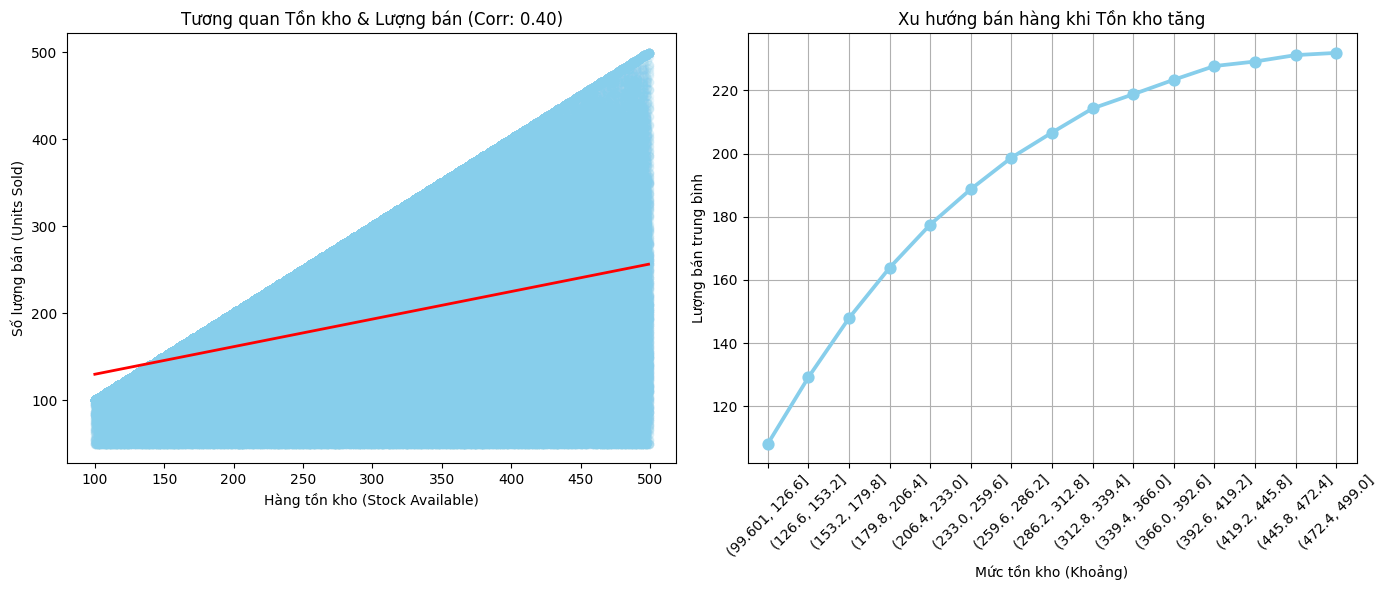

In [ ]:
# 2. Tính hệ số tương quan (Correlation)
corr_stock = df['stock_available'].corr(df['units_sold'])
print(f"Hệ số tương quan (Stock vs Sales): {corr_stock:.4f}")

# 3. Vẽ biểu đồ phân tích
plt.figure(figsize=(14, 6))

# --- Biểu đồ 1: Scatter Plot (Phân tán) ---
# Xem mật độ phân bố dữ liệu
ax1 = plt.subplot(1, 2, 1)
sns.regplot(data=df, x='stock_available', y='units_sold',
            scatter_kws={'alpha':0.1, 'color':'skyblue'},
            line_kws={'color':'red', 'linewidth': 2}, ax=ax1)
ax1.set_title(f'Tương quan Tồn kho & Lượng bán (Corr: {corr_stock:.2f})')
ax1.set_xlabel('Hàng tồn kho (Stock Available)')
ax1.set_ylabel('Số lượng bán (Units Sold)')

# --- Biểu đồ 2: Point Plot (Xu hướng trung bình) ---
# Chia tồn kho thành 15 khoảng (bins) để xem rõ xu hướng tăng giảm
ax2 = plt.subplot(1, 2, 2)
df['stock_bin'] = pd.cut(df['stock_available'], bins=15)
# Tính trung bình lượng bán cho mỗi khoảng tồn kho
stock_trends = df.groupby('stock_bin')['units_sold'].mean().reset_index()

sns.pointplot(data=stock_trends, x='stock_bin', y='units_sold', color='skyblue', markers='o', ax=ax2)
ax2.set_title('Xu hướng bán hàng khi Tồn kho tăng')
ax2.set_xlabel('Mức tồn kho (Khoảng)')
ax2.set_ylabel('Lượng bán trung bình')
ax2.tick_params(axis='x', rotation=45) # Xoay nhãn trục X 45 độ cho dễ đọc
ax2.grid(True)

plt.tight_layout()
plt.show()

Quy luật tự nhiên: Không thể bán nhiều hơn tồn kho

Tăng tồn kho là cực kỳ hiệu quả để kích thích doanh số khi hàng còn ít (tránh mất đơn), nhưng khi tồn kho đã đạt ngưỡng cao (khoảng trên 400 units), tác động biên của nó giảm dần

3.3. Quan hệ Đối thủ & Kinh tế (competitor_activity, economic_indicator vs units_sold)

Hệ số tương quan (Competitor vs Sales): -0.1323
Hệ số tương quan (Economic vs Sales): 0.1635


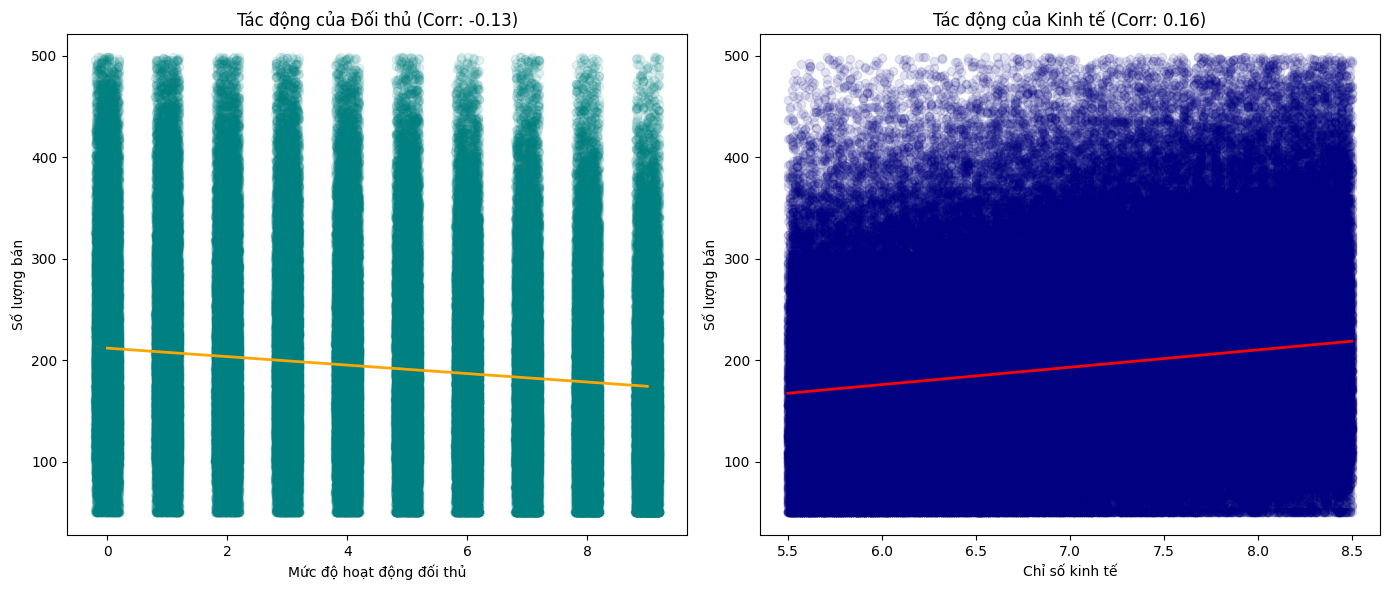

In [ ]:
# --- 2. Tính hệ số tương quan (Correlation) ---
# Xem các yếu tố bên ngoài ảnh hưởng thế nào đến lượng bán
corr_competitor = df['competitor_activity'].corr(df['units_sold'])
corr_economic = df['economic_indicator'].corr(df['units_sold'])

print(f"Hệ số tương quan (Competitor vs Sales): {corr_competitor:.4f}")
print(f"Hệ số tương quan (Economic vs Sales): {corr_economic:.4f}")

# --- 3. Vẽ biểu đồ phân tích ---
plt.figure(figsize=(14, 6))

# --- Biểu đồ 1: Competitor Activity vs Units Sold ---
# Dùng x_jitter vì chỉ số đối thủ thường là số nguyên
ax1 = plt.subplot(1, 2, 1)
sns.regplot(data=df, x='competitor_activity', y='units_sold', x_jitter=0.2,
            scatter_kws={'alpha': 0.1, 'color': 'teal'},   # Màu xanh két
            line_kws={'color': 'orange', 'linewidth': 2}, # Đường xu hướng màu cam
            ax=ax1)
ax1.set_title(f'Tác động của Đối thủ (Corr: {corr_competitor:.2f})')
ax1.set_xlabel('Mức độ hoạt động đối thủ')
ax1.set_ylabel('Số lượng bán')

# --- Biểu đồ 2: Economic Indicator vs Units Sold ---
# Chỉ số kinh tế thường là số thực liên tục
ax2 = plt.subplot(1, 2, 2)
sns.regplot(data=df, x='economic_indicator', y='units_sold',
            scatter_kws={'alpha': 0.1, 'color': 'navy'},  # Màu xanh đậm
            line_kws={'color': 'red', 'linewidth': 2},    # Đường xu hướng màu đỏ
            ax=ax2)
ax2.set_title(f'Tác động của Kinh tế (Corr: {corr_economic:.2f})')
ax2.set_xlabel('Chỉ số kinh tế')
ax2.set_ylabel('Số lượng bán')

plt.tight_layout()
plt.show()

Hoạt đông của đối thủ tác động tiêu cực đến doanh số nhưng yếu. Vì đường màu vàng lệch khá ít và ngay cả khi đôi thủ mạnh (mức 9) vẫn có 1 số đơn hàng 500.Đây có thể là doanh nghiệp đã có thương hiệu.

Khi nền kinh tế tốt thì doanh số cũng tốt theo.

4. Phân tích đa biến và chuỗi thời gian (MULTIVARIATE & TIME SERIES)

4.1. Phân tích Tương quan tổng thể (Correlation Matrix)

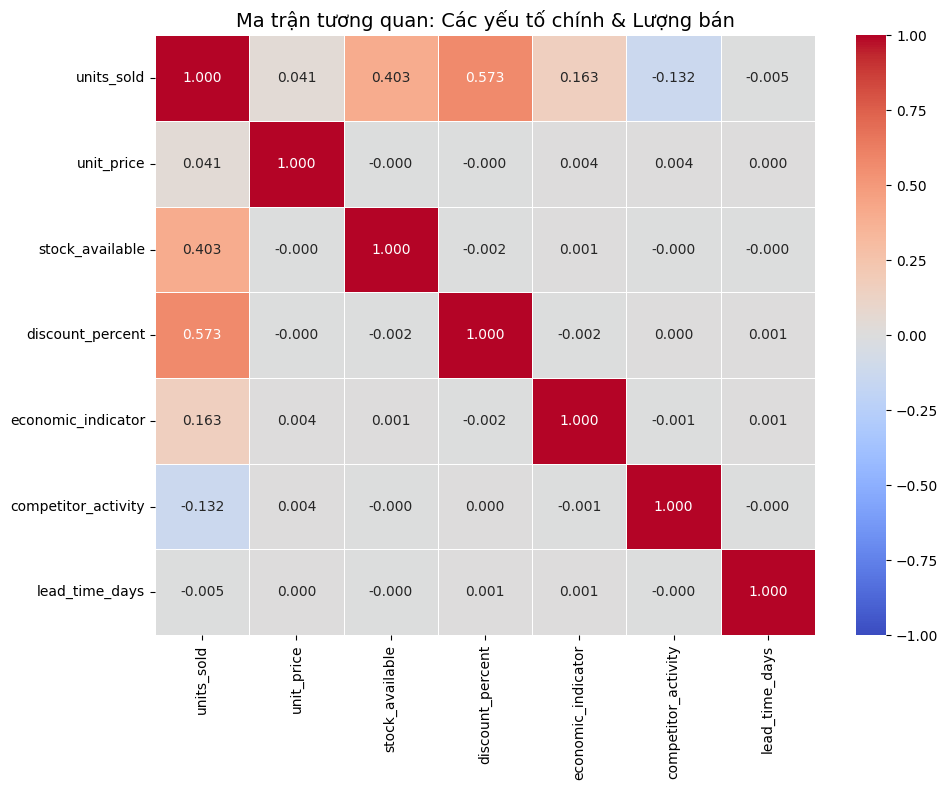

In [ ]:
# 1. Chọn các cột quan trọng cần phân tích
cols_to_analyze = [
    'units_sold',
    'unit_price',
    'stock_available',
    'discount_percent',
    'economic_indicator',
    'competitor_activity',
    'lead_time_days'
]

# Tạo một DataFrame con chỉ chứa các cột này
subset_df = df[cols_to_analyze]

# 2. Tính toán ma trận tương quan
corr_matrix = subset_df.corr()

# 3. Vẽ biểu đồ Heatmap
plt.figure(figsize=(10, 8)) # Kích thước vừa phải

sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm',
            linewidths=0.5, center=0, vmin=-1, vmax=1)

plt.title('Ma trận tương quan: Các yếu tố chính & Lượng bán', fontsize=14)
plt.tight_layout()
plt.show()

Doanh số (units_sold) chủ yếu được lái bởi các quyết định nội bộ: Cụ thể là chương trình Giảm giá (0.57) và khả năng cung ứng Hàng tồn kho (0.40).

Môi trường bên ngoài ít ảnh hưởng: Đối thủ và Kinh tế chỉ đóng vai trò thứ yếu.

Các biến độc lập không có sự tương quan chéo (hệ số ~0), đây là điều kiện lý tưởng để xây dựng các mô hình dự báo chính xác mà không cần xử lý đa cộng tuyến.

4.2. Phân tích theo Thời gian (Time Series Decomposition)

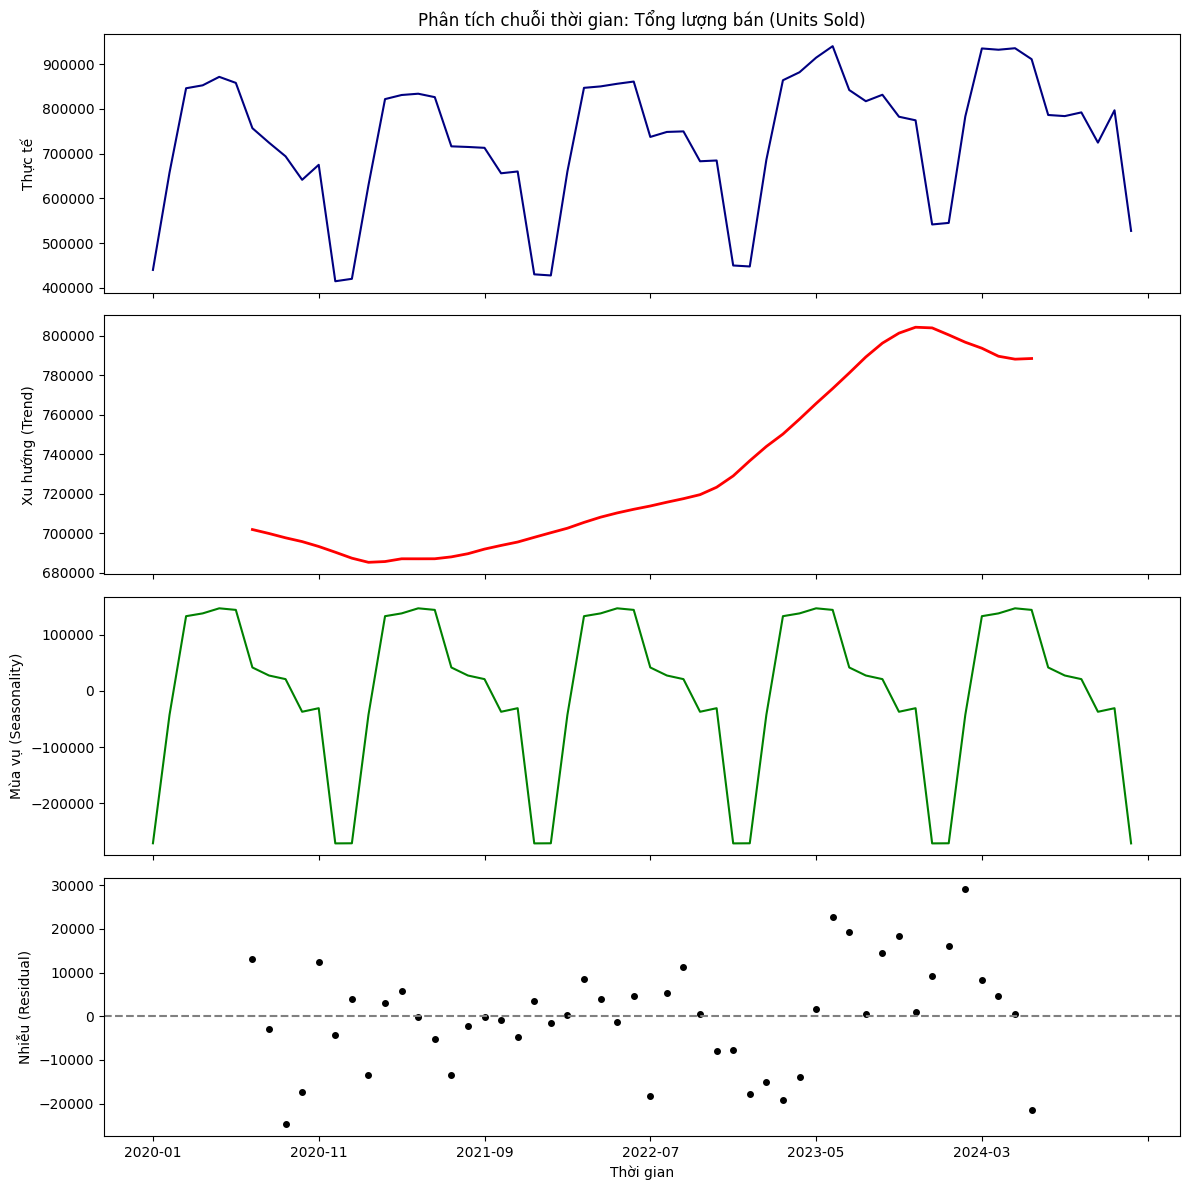

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

monthly_sales = df.groupby('date')['units_sold'].sum().sort_index()

# 2. Thực hiện phân rã (Decomposition)
# model='additive': Mô hình cộng (Dữ liệu = Trend + Seasonality + Residual)
# period=12: Chu kỳ 12 tháng (vì dữ liệu theo tháng)
result = seasonal_decompose(monthly_sales, model='additive', period=12)

# 3. Vẽ biểu đồ trực quan hóa
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Biểu đồ gốc (Observed)
result.observed.plot(ax=ax1, color='navy')
ax1.set_title('Phân tích chuỗi thời gian: Tổng lượng bán (Units Sold)')
ax1.set_ylabel('Thực tế')

# Biểu đồ Xu hướng (Trend)
result.trend.plot(ax=ax2, color='red', linewidth=2)
ax2.set_ylabel('Xu hướng (Trend)')

# Biểu đồ Mùa vụ (Seasonality)
result.seasonal.plot(ax=ax3, color='green')
ax3.set_ylabel('Mùa vụ (Seasonality)')

# Biểu đồ Nhiễu/Dư (Residual)
result.resid.plot(ax=ax4, color='black', linestyle='None', marker='o', markersize=4)
ax4.axhline(0, color='gray', linestyle='--') # Đường tham chiếu 0
ax4.set_ylabel('Nhiễu (Residual)')

plt.xlabel('Thời gian')
plt.tight_layout()
plt.show()



1.   Trend

Giai đoạn 2020: Xu hướng đi ngang và giảm nhẹ (có thể do tác động ngoại cảnh hoặc giai đoạn đầu của sản phẩm).

Giai đoạn Tăng trưởng (2021 - giữa 2023): Đường xu hướng dốc lên mạnh mẽ và ổn định. Đây là giai đoạn doanh nghiệp mở rộng thị phần tốt nhất.

Giai đoạn Bão hòa (Cuối 2023 - 2024): Đường xu hướng bắt đầu đi ngang và có dấu hiệu cong xuống nhẹ ở phần đuôi.

==> Xu hướng dài hạn cho thấy chúng ta đã qua giai đoạn tăng trưởng nóng và đang đi vào vùng bão hòa. Điều này cảnh báo rằng nếu không có chiến lược mới, doanh số cơ sở (baseline sales) có thể sẽ giảm trong tương lai gần.

2.   Mùa vụ: có tính mùa vụ cao
==> Mô hình thống kê truyền thống đề xuất: SARIMA, Holt-Winters


4.3. Phân tích Tương tác (Interaction Analysis)

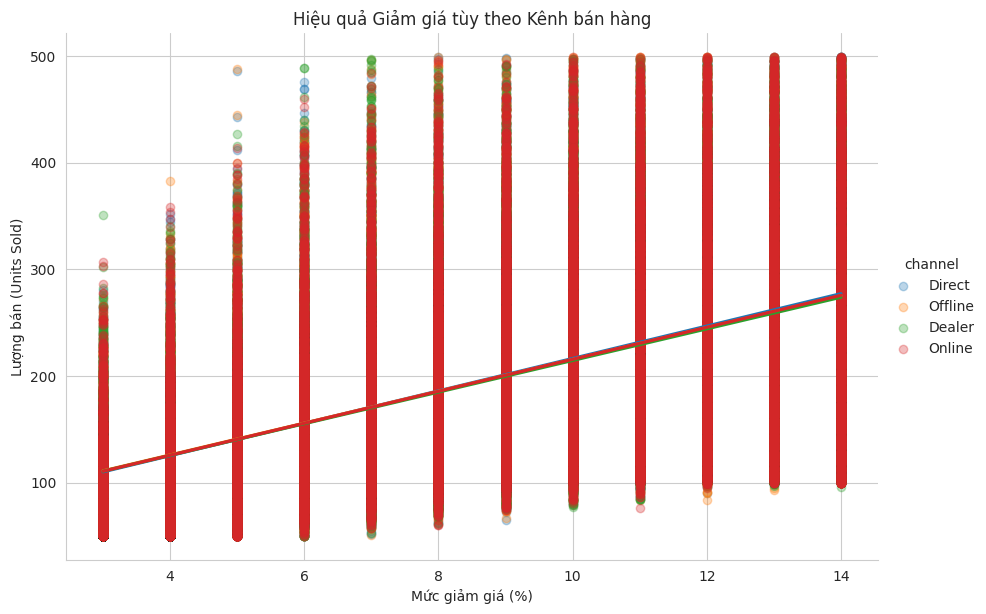

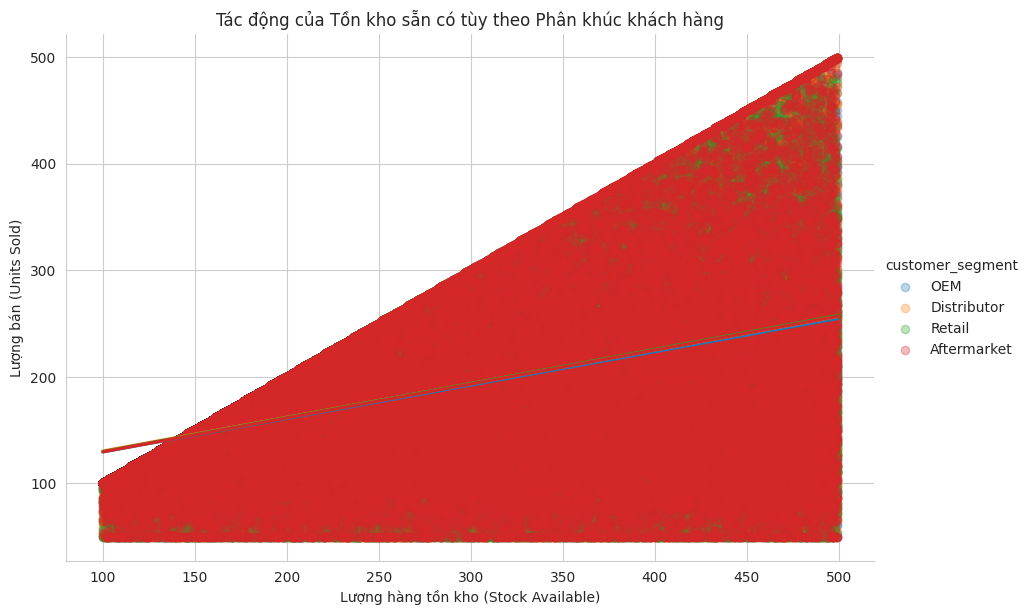

In [ ]:
# --- Phân tích Tương tác (Interaction Analysis) ---
sns.set_style("whitegrid")

# 1. Tương tác: Giảm giá vs Kênh bán hàng (Giữ nguyên)
# Xem kênh nào (Online/Offline) phản ứng mạnh nhất với giảm giá
sns.lmplot(data=df, x='discount_percent', y='units_sold', hue='channel',
           height=6, aspect=1.5, ci=None,
           scatter_kws={'alpha': 0.3})
plt.title('Hiệu quả Giảm giá tùy theo Kênh bán hàng')
plt.ylabel('Lượng bán (Units Sold)')
plt.xlabel('Mức giảm giá (%)')

# 2. Tương tác: Tồn kho vs Phân khúc khách hàng (MỚI)
# Thay thế Unit Price bằng Stock Available
# Mục đích: Xem nhóm khách nào quan tâm nhất đến việc hàng có sẵn (Stock)
# Nếu đường dốc lên: Khách mua nhiều hơn khi thấy kho nhiều hàng (tâm lý khan hiếm hoặc tin cậy nguồn cung).
sns.lmplot(data=df, x='stock_available', y='units_sold', hue='customer_segment',
           height=6, aspect=1.5, ci=None,
           scatter_kws={'alpha': 0.3})
plt.title('Tác động của Tồn kho sẵn có tùy theo Phân khúc khách hàng')
plt.ylabel('Lượng bán (Units Sold)')
plt.xlabel('Lượng hàng tồn kho (Stock Available)')

plt.show()

### MÔ HÌNH HOÁ DỮ LIỆU

#### MOVING AVERAGE (5 tháng)

1. THỰC HIỆN (CHIA TRAIN/TEST, HUẤN LUYỆN, DỰ BÁO VÀ ĐÁNH GIÁ)

In [ ]:
pairs = df_master[['region', 'country']].drop_duplicates().values.tolist()

metrics = []
forecast_results = {}
window_size = 5 # <--- THAM SỐ CỦA BẠN (5 THÁNG)

print(f"--- Bắt đầu chạy Moving Average ({window_size} months) cho {len(pairs)} thị trường ---")

for i, (region, country) in enumerate(pairs):
    print(f"[{i+1}/{len(pairs)}] {region} - {country}...", end=" ")

    # Lấy dữ liệu
    subset = df_master[(df_master['region'] == region) & (df_master['country'] == country)]
    # Đảm bảo index liên tục theo tháng
    ts_data = subset.set_index('date').asfreq('MS')['units_sold'].fillna(0)

    # Kiểm tra độ dài
    if len(ts_data) < 24:
        print("-> SKIP (Ít dữ liệu)")
        continue

    # Chia Train/Test
    test_len = 12
    train = ts_data.iloc[:-test_len]
    test = ts_data.iloc[-test_len:]

    try:
        # --- CẤU HÌNH MOVING AVERAGE ---
        # Tính MA trên toàn bộ chuỗi (để lấy được đuôi của Train đắp vào đầu Test)
        # shift(1) nghĩa là: Dự báo tháng này = Trung bình 5 tháng TRƯỚC ĐÓ
        full_ma = ts_data.rolling(window=window_size).mean().shift(1)

        # Chỉ lấy phần dự báo tương ứng với tập Test
        preds = full_ma.loc[test.index]

        # Xử lý trường hợp NaN (5 tháng đầu tiên của dữ liệu sẽ là NaN, nhưng Test thì chắc chắn có số vì Train dài hơn 5)
        preds = preds.fillna(0)

        # Tính toán chỉ số
        mape = mean_absolute_percentage_error(test, preds) * 100
        rmse = np.sqrt(mean_squared_error(test, preds))
        mae = mean_absolute_error(test, preds)
        r2 = r2_score(test, preds)

        metrics.append({
            'Region': region,
            'Country': country,
            'MAPE (%)': mape,
            'RMSE': rmse,
            'MAE': mae,
            'R2 Score': r2
        })

        forecast_results[(region, country)] = {
            'train': train,
            'test': test,
            'preds': preds,
            'mape': mape,
            'r2': r2
        }
        print("-> Xong.")

    except Exception as e:
        print(f"-> Lỗi: {e}")

--- Bắt đầu chạy Moving Average (5 months) cho 16 thị trường ---
[1/16] East - Brazil... -> Xong.
[2/16] East - Germany... -> Xong.
[3/16] East - India... -> Xong.
[4/16] East - USA... -> Xong.
[5/16] North - Brazil... -> Xong.
[6/16] North - Germany... -> Xong.
[7/16] North - India... -> Xong.
[8/16] North - USA... -> Xong.
[9/16] South - Brazil... -> Xong.
[10/16] South - Germany... -> Xong.
[11/16] South - India... -> Xong.
[12/16] South - USA... -> Xong.
[13/16] West - Brazil... -> Xong.
[14/16] West - Germany... -> Xong.
[15/16] West - India... -> Xong.
[16/16] West - USA... -> Xong.


2. KẾT QUẢ


KẾT QUẢ TRUNG BÌNH MOVING AVERAGE (5 THÁNG)
MAPE (%)       19.435635
RMSE        10127.103665
MAE          8984.822917
R2 Score       -0.468341
dtype: float64

TOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT:
   Region  Country   MAPE (%)  R2 Score
10  South    India  17.465620 -0.510275
15   West      USA  17.783893 -0.487188
3    East      USA  18.698491 -0.474351
9   South  Germany  18.833544 -0.506410
12   West   Brazil  19.048967 -0.422534

--- Đang vẽ biểu đồ MA(5) ---


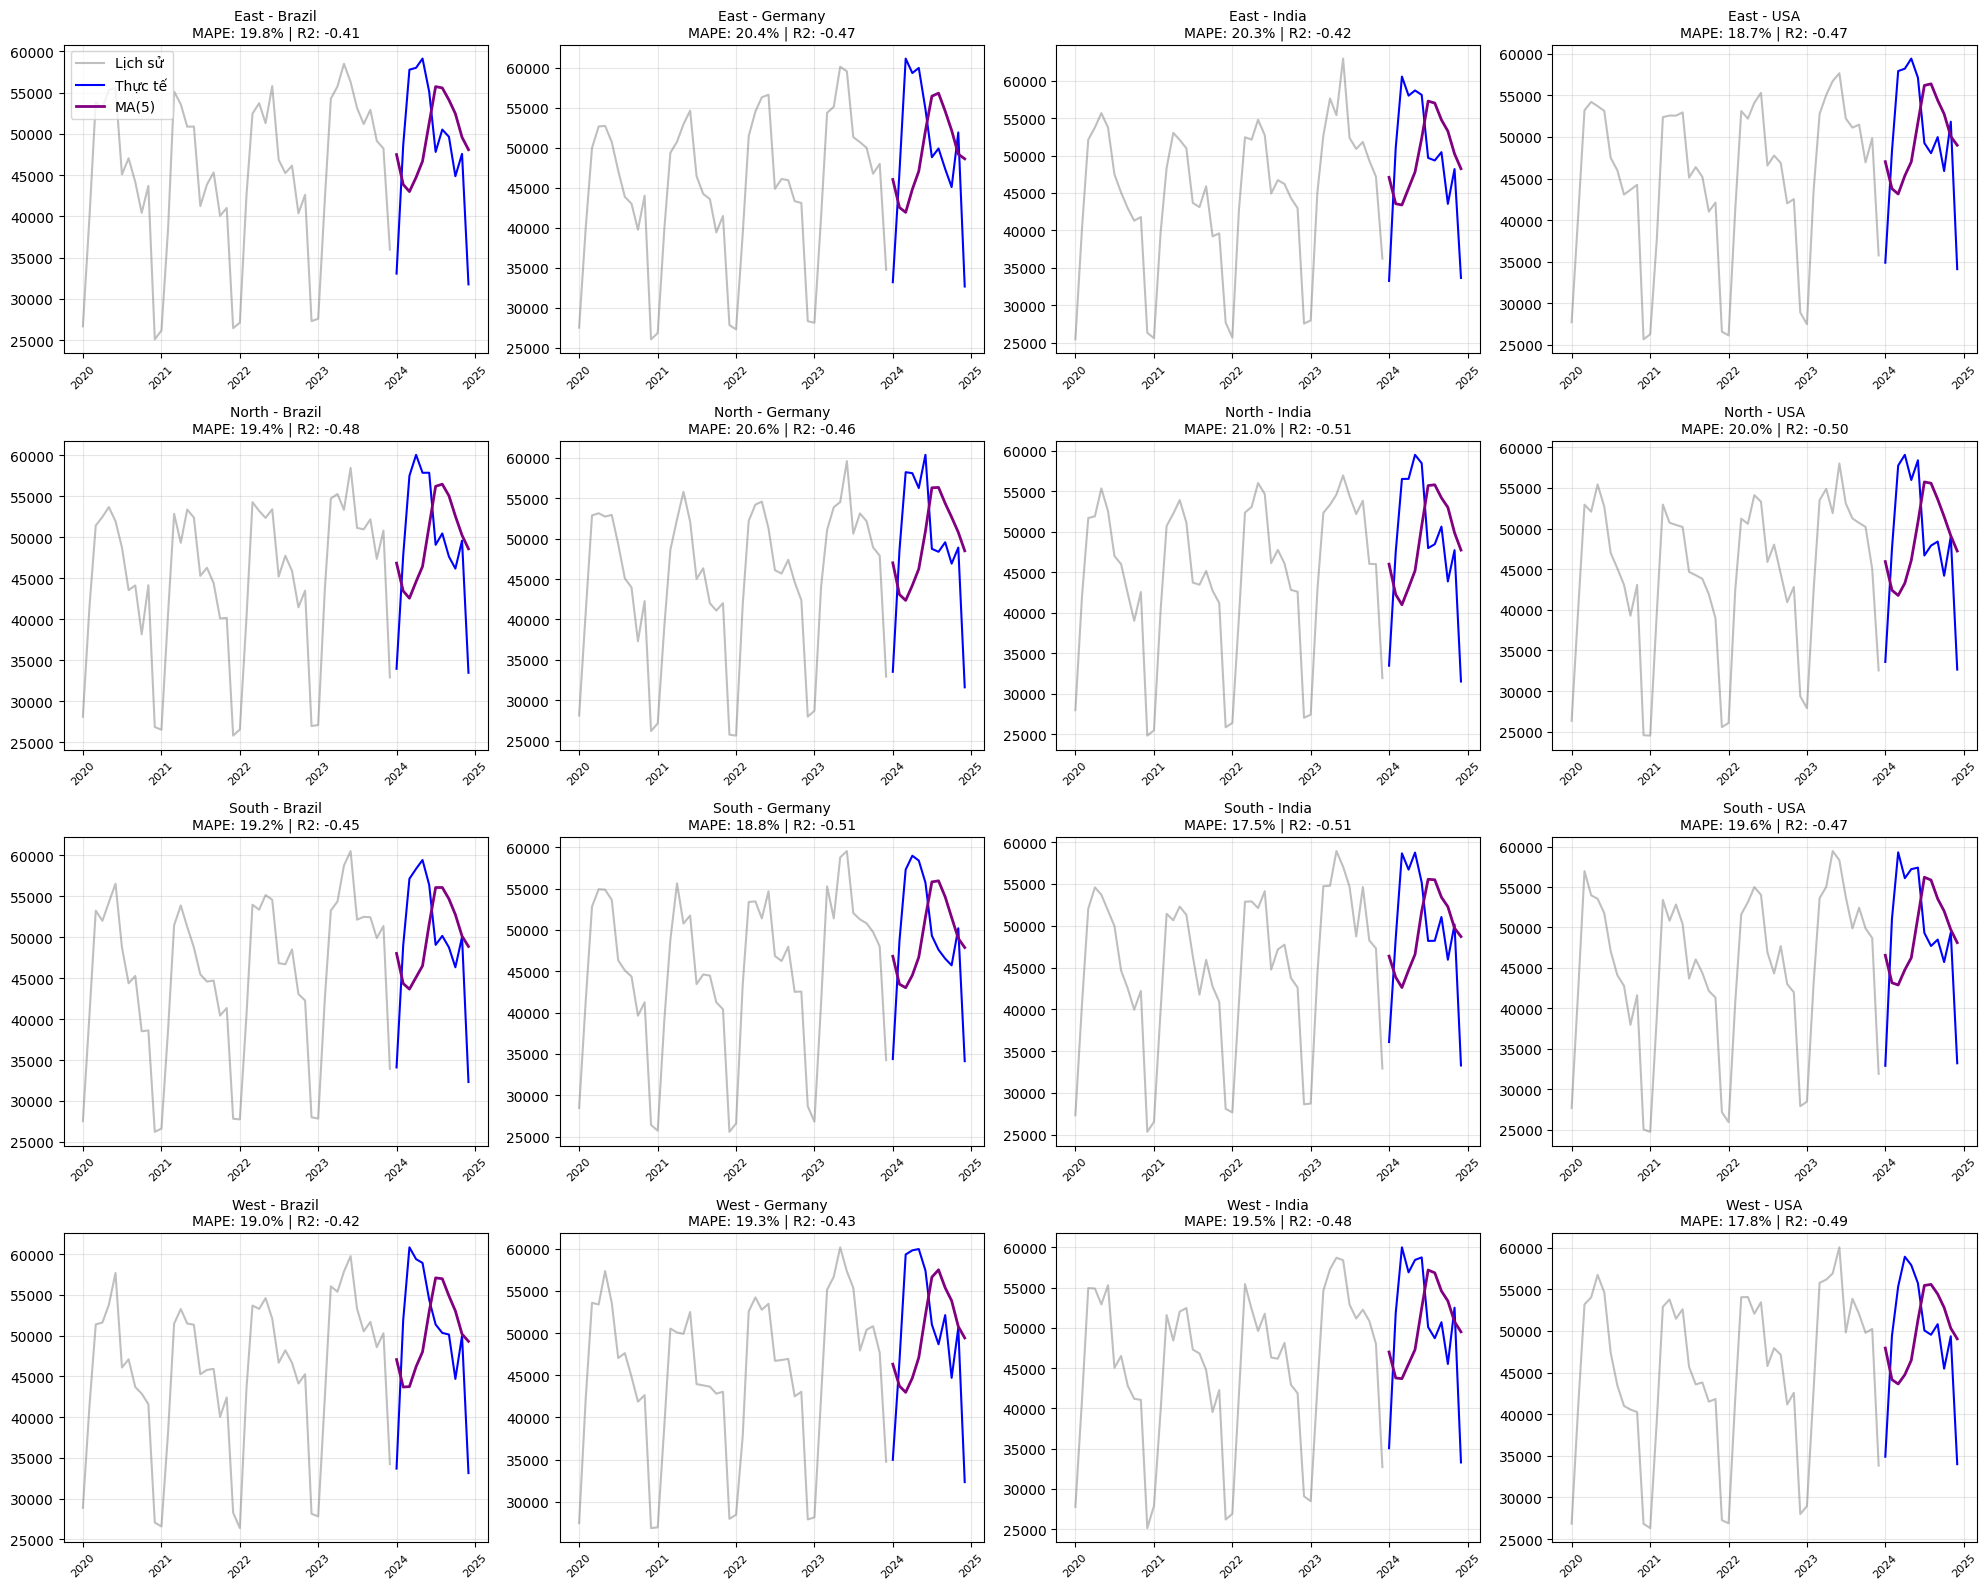

In [ ]:
# 1. Báo cáo Tổng hợp
results_df = pd.DataFrame(metrics)

print("\n" + "="*50)
print(f"KẾT QUẢ TRUNG BÌNH MOVING AVERAGE ({window_size} THÁNG)")
print("="*50)
print(results_df[['MAPE (%)', 'RMSE', 'MAE', 'R2 Score']].mean())

print("\nTOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT:")
print(results_df.sort_values('MAPE (%)').head(5)[['Region', 'Country', 'MAPE (%)', 'R2 Score']])

# 2. Vẽ biểu đồ Grid
valid_pairs = list(forecast_results.keys())
n_charts = len(valid_pairs)
n_cols = 4
n_rows = math.ceil(n_charts / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

print(f"\n--- Đang vẽ biểu đồ MA({window_size}) ---")

for i, (region, country) in enumerate(valid_pairs):
    ax = axes[i]
    data = forecast_results[(region, country)]

    # Vẽ
    ax.plot(data['train'].index, data['train'], label='Lịch sử', color='gray', alpha=0.5)
    ax.plot(data['test'].index, data['test'], label='Thực tế', color='blue')
    ax.plot(data['preds'].index, data['preds'], label=f'MA({window_size})', color='purple', linestyle='-', linewidth=2)

    ax.set_title(f"{region} - {country}\nMAPE: {data['mape']:.1f}% | R2: {data['r2']:.2f}", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3)

    if i == 0: ax.legend(loc='upper left')

# Xóa khung hình dư
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### MOVING AVERAGE (10 tháng)

1. THỰC HIỆN (CHIA TRAIN/TEST, HUẤN LUYỆN, DỰ BÁO VÀ ĐÁNH GIÁ)

In [ ]:
pairs = df_master[['region', 'country']].drop_duplicates().values.tolist()

metrics = []
forecast_results = {}
window_size = 10 # <--- ĐÃ ĐỔI THÀNH 10

print(f"--- Bắt đầu chạy Moving Average (Window={window_size}) cho {len(pairs)} thị trường ---")

for i, (region, country) in enumerate(pairs):
    print(f"[{i+1}/{len(pairs)}] {region} - {country}...", end=" ")

    # Lấy dữ liệu
    subset = df_master[(df_master['region'] == region) & (df_master['country'] == country)]
    ts_data = subset.set_index('date').asfreq('MS')['units_sold'].fillna(0)

    # Kiểm tra độ dài
    # Cần ít nhất: window_size (10) + test_len (12) + 1 vài tháng đệm = khoảng 24
    if len(ts_data) < 24:
        print("-> SKIP (Ít dữ liệu)")
        continue

    # Chia Train/Test
    test_len = 12
    train = ts_data.iloc[:-test_len]
    test = ts_data.iloc[-test_len:]

    try:
        # --- CẤU HÌNH MA(10) ---
        # Tính MA trên toàn bộ chuỗi
        full_ma = ts_data.rolling(window=window_size).mean().shift(1)

        # Chỉ lấy phần dự báo tương ứng với tập Test
        preds = full_ma.loc[test.index]
        preds = preds.fillna(0)

        # Tính toán chỉ số
        mape = mean_absolute_percentage_error(test, preds) * 100
        rmse = np.sqrt(mean_squared_error(test, preds))
        mae = mean_absolute_error(test, preds)
        r2 = r2_score(test, preds)

        metrics.append({
            'Region': region,
            'Country': country,
            'MAPE (%)': mape,
            'RMSE': rmse,
            'MAE': mae,
            'R2 Score': r2
        })

        forecast_results[(region, country)] = {
            'train': train,
            'test': test,
            'preds': preds,
            'mape': mape,
            'r2': r2
        }
        print("-> Xong.")

    except Exception as e:
        print(f"-> Lỗi: {e}")

--- Bắt đầu chạy Moving Average (Window=10) cho 16 thị trường ---
[1/16] East - Brazil... -> Xong.
[2/16] East - Germany... -> Xong.
[3/16] East - India... -> Xong.
[4/16] East - USA... -> Xong.
[5/16] North - Brazil... -> Xong.
[6/16] North - Germany... -> Xong.
[7/16] North - India... -> Xong.
[8/16] North - USA... -> Xong.
[9/16] South - Brazil... -> Xong.
[10/16] South - Germany... -> Xong.
[11/16] South - India... -> Xong.
[12/16] South - USA... -> Xong.
[13/16] West - Brazil... -> Xong.
[14/16] West - Germany... -> Xong.
[15/16] West - India... -> Xong.
[16/16] West - USA... -> Xong.


2. KẾT QUẢ


KẾT QUẢ TRUNG BÌNH MOVING AVERAGE (10 THÁNG)
MAPE (%)      16.176818
RMSE        9375.880064
MAE         6962.127604
R2 Score      -0.257933
dtype: float64

TOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT:
   Region  Country   MAPE (%)  R2 Score
15   West      USA  14.419768 -0.280355
10  South    India  14.770796 -0.267645
9   South  Germany  15.036521 -0.237544
3    East      USA  15.188171 -0.260036
8   South   Brazil  15.737322 -0.246271

--- Đang vẽ biểu đồ MA(10) ---


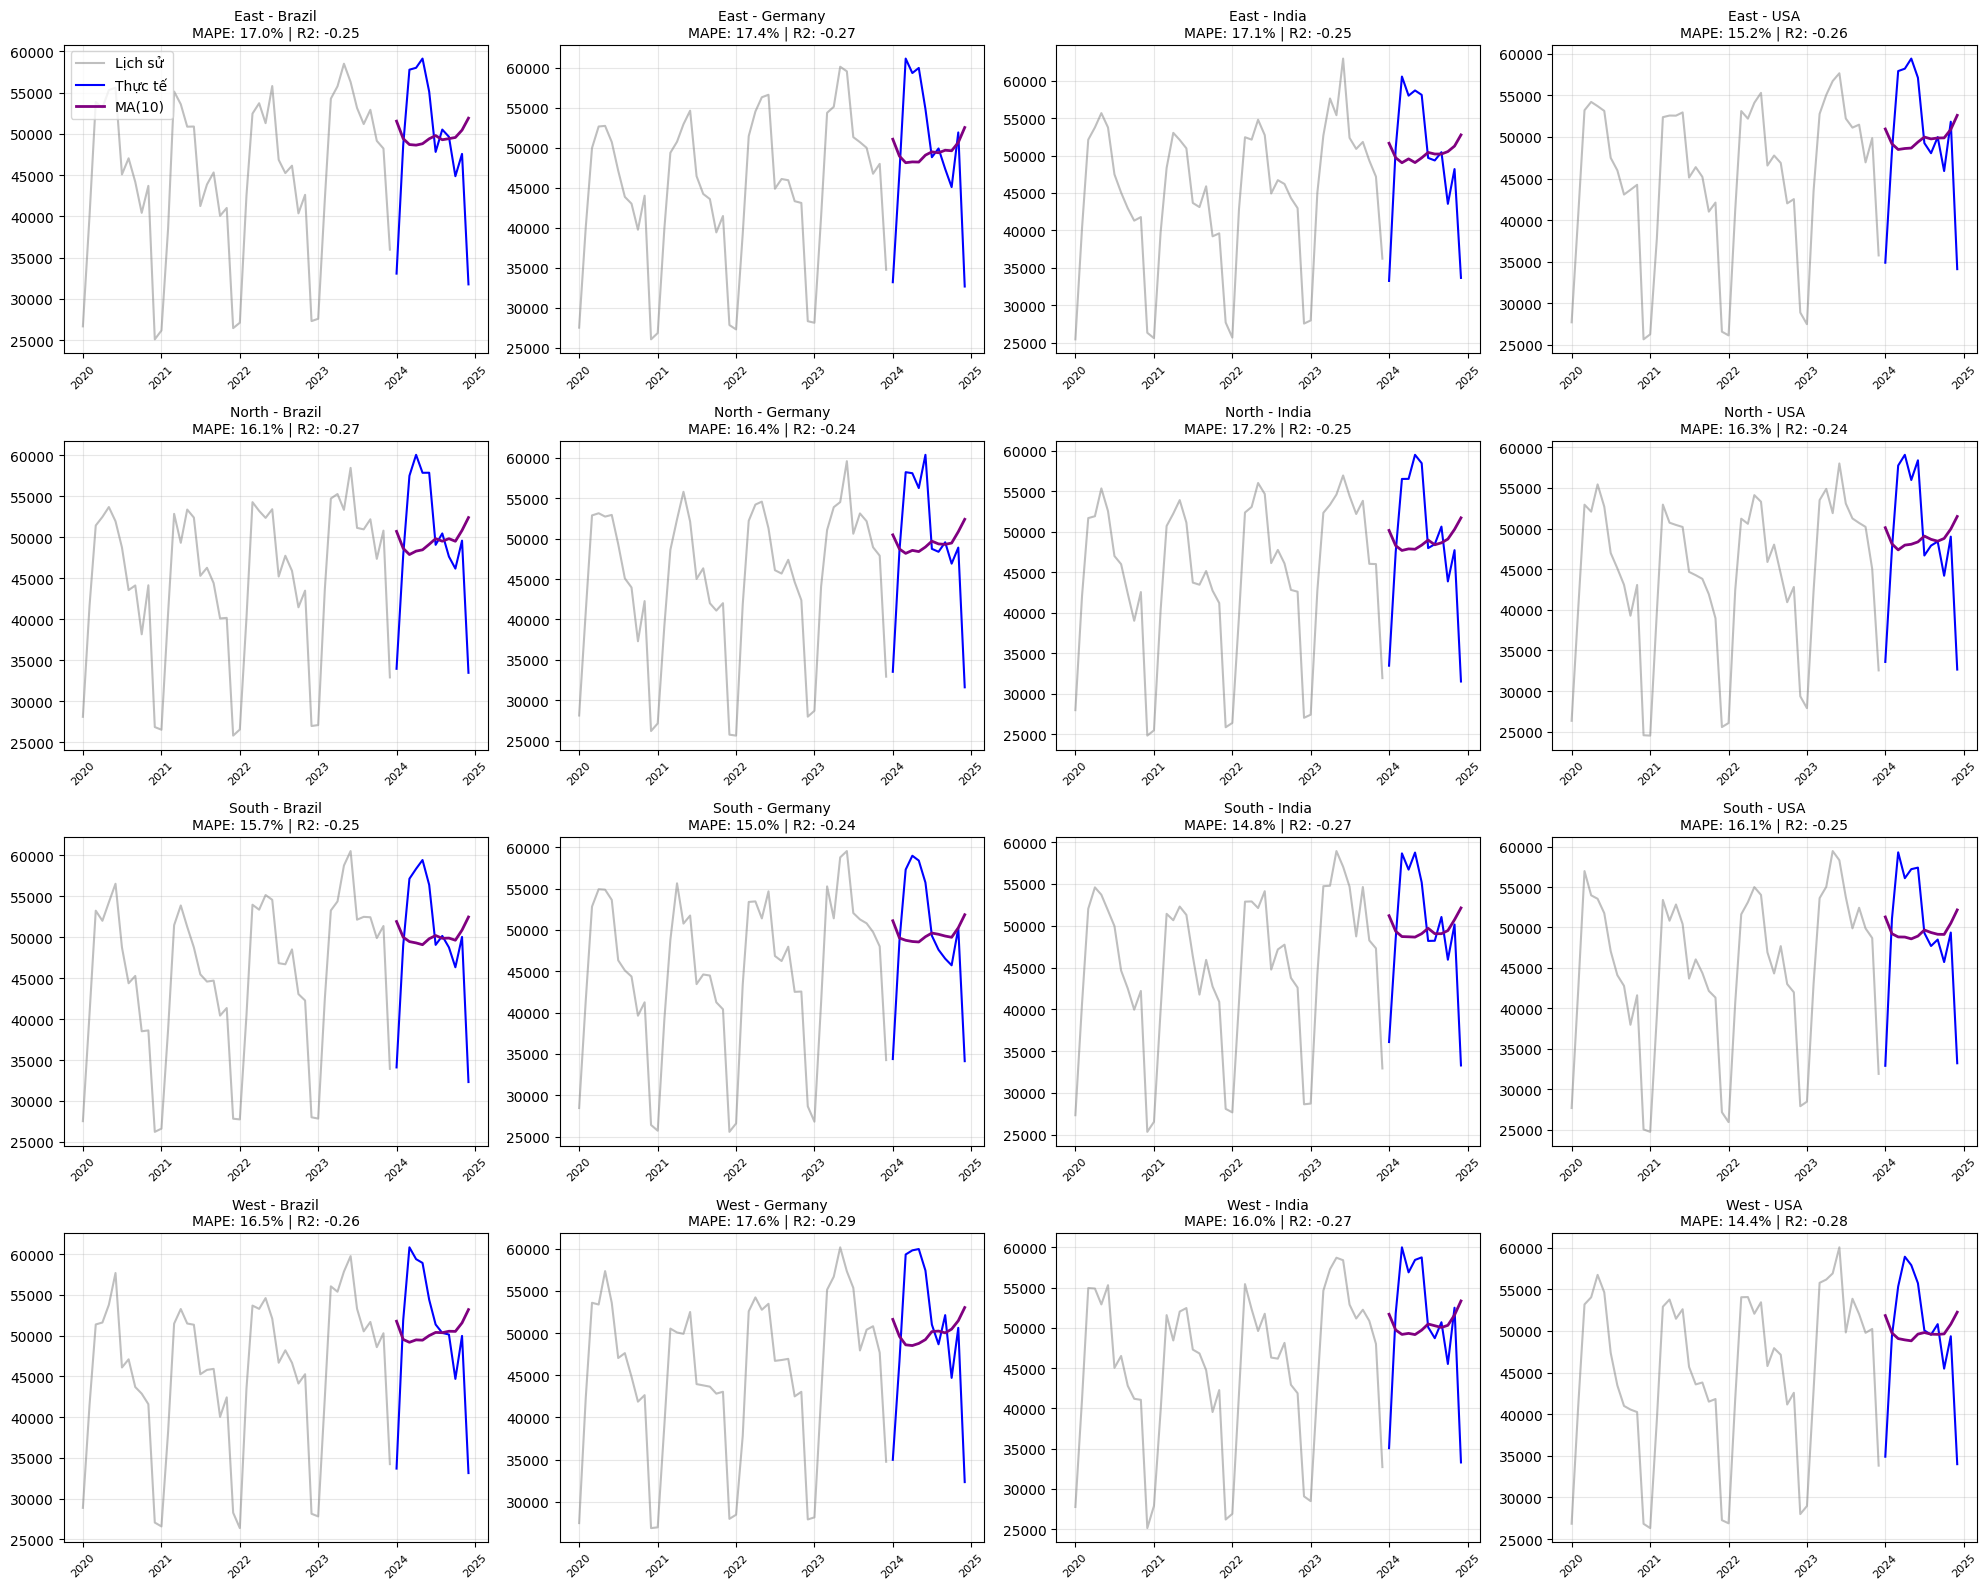

In [ ]:
# 1. Báo cáo Tổng hợp
results_df = pd.DataFrame(metrics)

print("\n" + "="*50)
print(f"KẾT QUẢ TRUNG BÌNH MOVING AVERAGE ({window_size} THÁNG)")
print("="*50)
print(results_df[['MAPE (%)', 'RMSE', 'MAE', 'R2 Score']].mean())

print("\nTOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT:")
print(results_df.sort_values('MAPE (%)').head(5)[['Region', 'Country', 'MAPE (%)', 'R2 Score']])

# 2. Vẽ biểu đồ Grid
valid_pairs = list(forecast_results.keys())
n_charts = len(valid_pairs)
n_cols = 4
n_rows = math.ceil(n_charts / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

print(f"\n--- Đang vẽ biểu đồ MA({window_size}) ---")

for i, (region, country) in enumerate(valid_pairs):
    ax = axes[i]
    data = forecast_results[(region, country)]

    # Vẽ
    ax.plot(data['train'].index, data['train'], label='Lịch sử', color='gray', alpha=0.5)
    ax.plot(data['test'].index, data['test'], label='Thực tế', color='blue')
    ax.plot(data['preds'].index, data['preds'], label=f'MA({window_size})', color='purple', linestyle='-', linewidth=2)

    ax.set_title(f"{region} - {country}\nMAPE: {data['mape']:.1f}% | R2: {data['r2']:.2f}", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3)

    if i == 0: ax.legend(loc='upper left')

# Xóa khung hình dư
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### SARIMA(0,1,0)(0,1,0)12​

1. TÌM BỘ THAM SỐ CHUẨN (AUTO ARIMA)

In [ ]:
# Gom toàn bộ dữ liệu (Global)
df_total = df.groupby('date')['units_sold'].sum().asfreq('MS').fillna(0)
train_total = df_total.iloc[:-12]

print("--- Đang tìm bộ tham số tốt nhất trên dữ liệu TỔNG... ---")
# Chạy Auto ARIMA trên tổng thể
global_model = pm.auto_arima(train_total, seasonal=True, m=12,
                             stepwise=True, suppress_warnings=True)

# Lấy tham số ra
my_order = global_model.order           # Ví dụ: (1, 1, 1)
my_seasonal = global_model.seasonal_order # Ví dụ: (0, 1, 1, 12)

print(f"\n=> Đã chốt bộ tham số chung (Global Params):")
print(f"   Order: {my_order}")
print(f"   Seasonal Order: {my_seasonal}")
print("-" * 40)

--- Đang tìm bộ tham số tốt nhất trên dữ liệu TỔNG... ---

=> Đã chốt bộ tham số chung (Global Params):
   Order: (0, 1, 0)
   Seasonal Order: (0, 1, 0, 12)
----------------------------------------


2. THỰC HIỆN (CHIA TRAIN/TEST, HUẤN LUYỆN, DỰ BÁO VÀ ĐÁNH GIÁ)

In [ ]:
# 1. Chuẩn bị dữ liệu
# Đảm bảo df_master, my_order, my_seasonal đã có từ các bước trước
pairs = df_master[['region', 'country']].drop_duplicates().values.tolist()

metrics = []
forecast_results = {} # <--- Biến quan trọng để lưu dữ liệu cho việc vẽ ở Cell sau

print(f"--- Đang chạy mô hình cho {len(pairs)} thị trường ---")

for i, (region, country) in enumerate(pairs):
    print(f"[{i+1}/{len(pairs)}] {region} - {country}...", end=" ")

    # Lấy dữ liệu
    subset = df_master[(df_master['region'] == region) & (df_master['country'] == country)]
    ts_data = subset.set_index('date').asfreq('MS')['units_sold'].fillna(0)

    # Kiểm tra độ dài
    if len(ts_data) < 24:
        print("-> SKIP (Ít dữ liệu)")
        continue

    # Chia Train/Test
    test_len = 12
    train = ts_data.iloc[:-test_len]
    test = ts_data.iloc[-test_len:]

    try:
        # Huấn luyện (Dùng tham số chung)
        model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        # Dự báo
        preds = model_fit.forecast(steps=test_len)

        # Tính toán chỉ số
        mape = mean_absolute_percentage_error(test, preds) * 100
        rmse = np.sqrt(mean_squared_error(test, preds))
        mae = mean_absolute_error(test, preds)
        r2 = r2_score(test, preds)

        # Lưu vào danh sách để làm báo cáo
        metrics.append({
            'Region': region,
            'Country': country,
            'MAPE (%)': mape,
            'RMSE': rmse,
            'MAE': mae,
            'R2 Score': r2
        })

        # Lưu dữ liệu chuỗi số để vẽ biểu đồ ở Cell sau
        forecast_results[(region, country)] = {
            'train': train,
            'test': test,
            'preds': preds,
            'mape': mape,
            'r2': r2
        }
        print("-> Xong.")

    except Exception as e:
        print(f"-> Lỗi: {e}")


--- Đang chạy mô hình cho 16 thị trường ---
[1/16] East - Brazil... -> Xong.
[2/16] East - Germany... -> Xong.
[3/16] East - India... -> Xong.
[4/16] East - USA... -> Xong.
[5/16] North - Brazil... -> Xong.
[6/16] North - Germany... -> Xong.
[7/16] North - India... -> Xong.
[8/16] North - USA... -> Xong.
[9/16] South - Brazil... -> Xong.
[10/16] South - Germany... -> Xong.
[11/16] South - India... -> Xong.
[12/16] South - USA... -> Xong.
[13/16] West - Brazil... -> Xong.
[14/16] West - Germany... -> Xong.
[15/16] West - India... -> Xong.
[16/16] West - USA... -> Xong.


3. KẾT QUẢ

KẾT QUẢ HIỆU SUẤT TRUNG BÌNH (TOÀN CỤC)
MAPE (%)      11.621521
RMSE        6433.900458
MAE         5527.098958
R2 Score       0.384733
dtype: float64

TOP 5 THỊ TRƯỜNG TỐT NHẤT (MAPE THẤP NHẤT)
   Region  Country  MAPE (%)  R2 Score
7   North      USA  8.236759  0.670106
14   West    India  8.984791  0.659495
10  South    India  9.070000  0.531441
6   North    India  9.228980  0.581600
5   North  Germany  9.260985  0.627193

--- Đang vẽ 16 biểu đồ ---


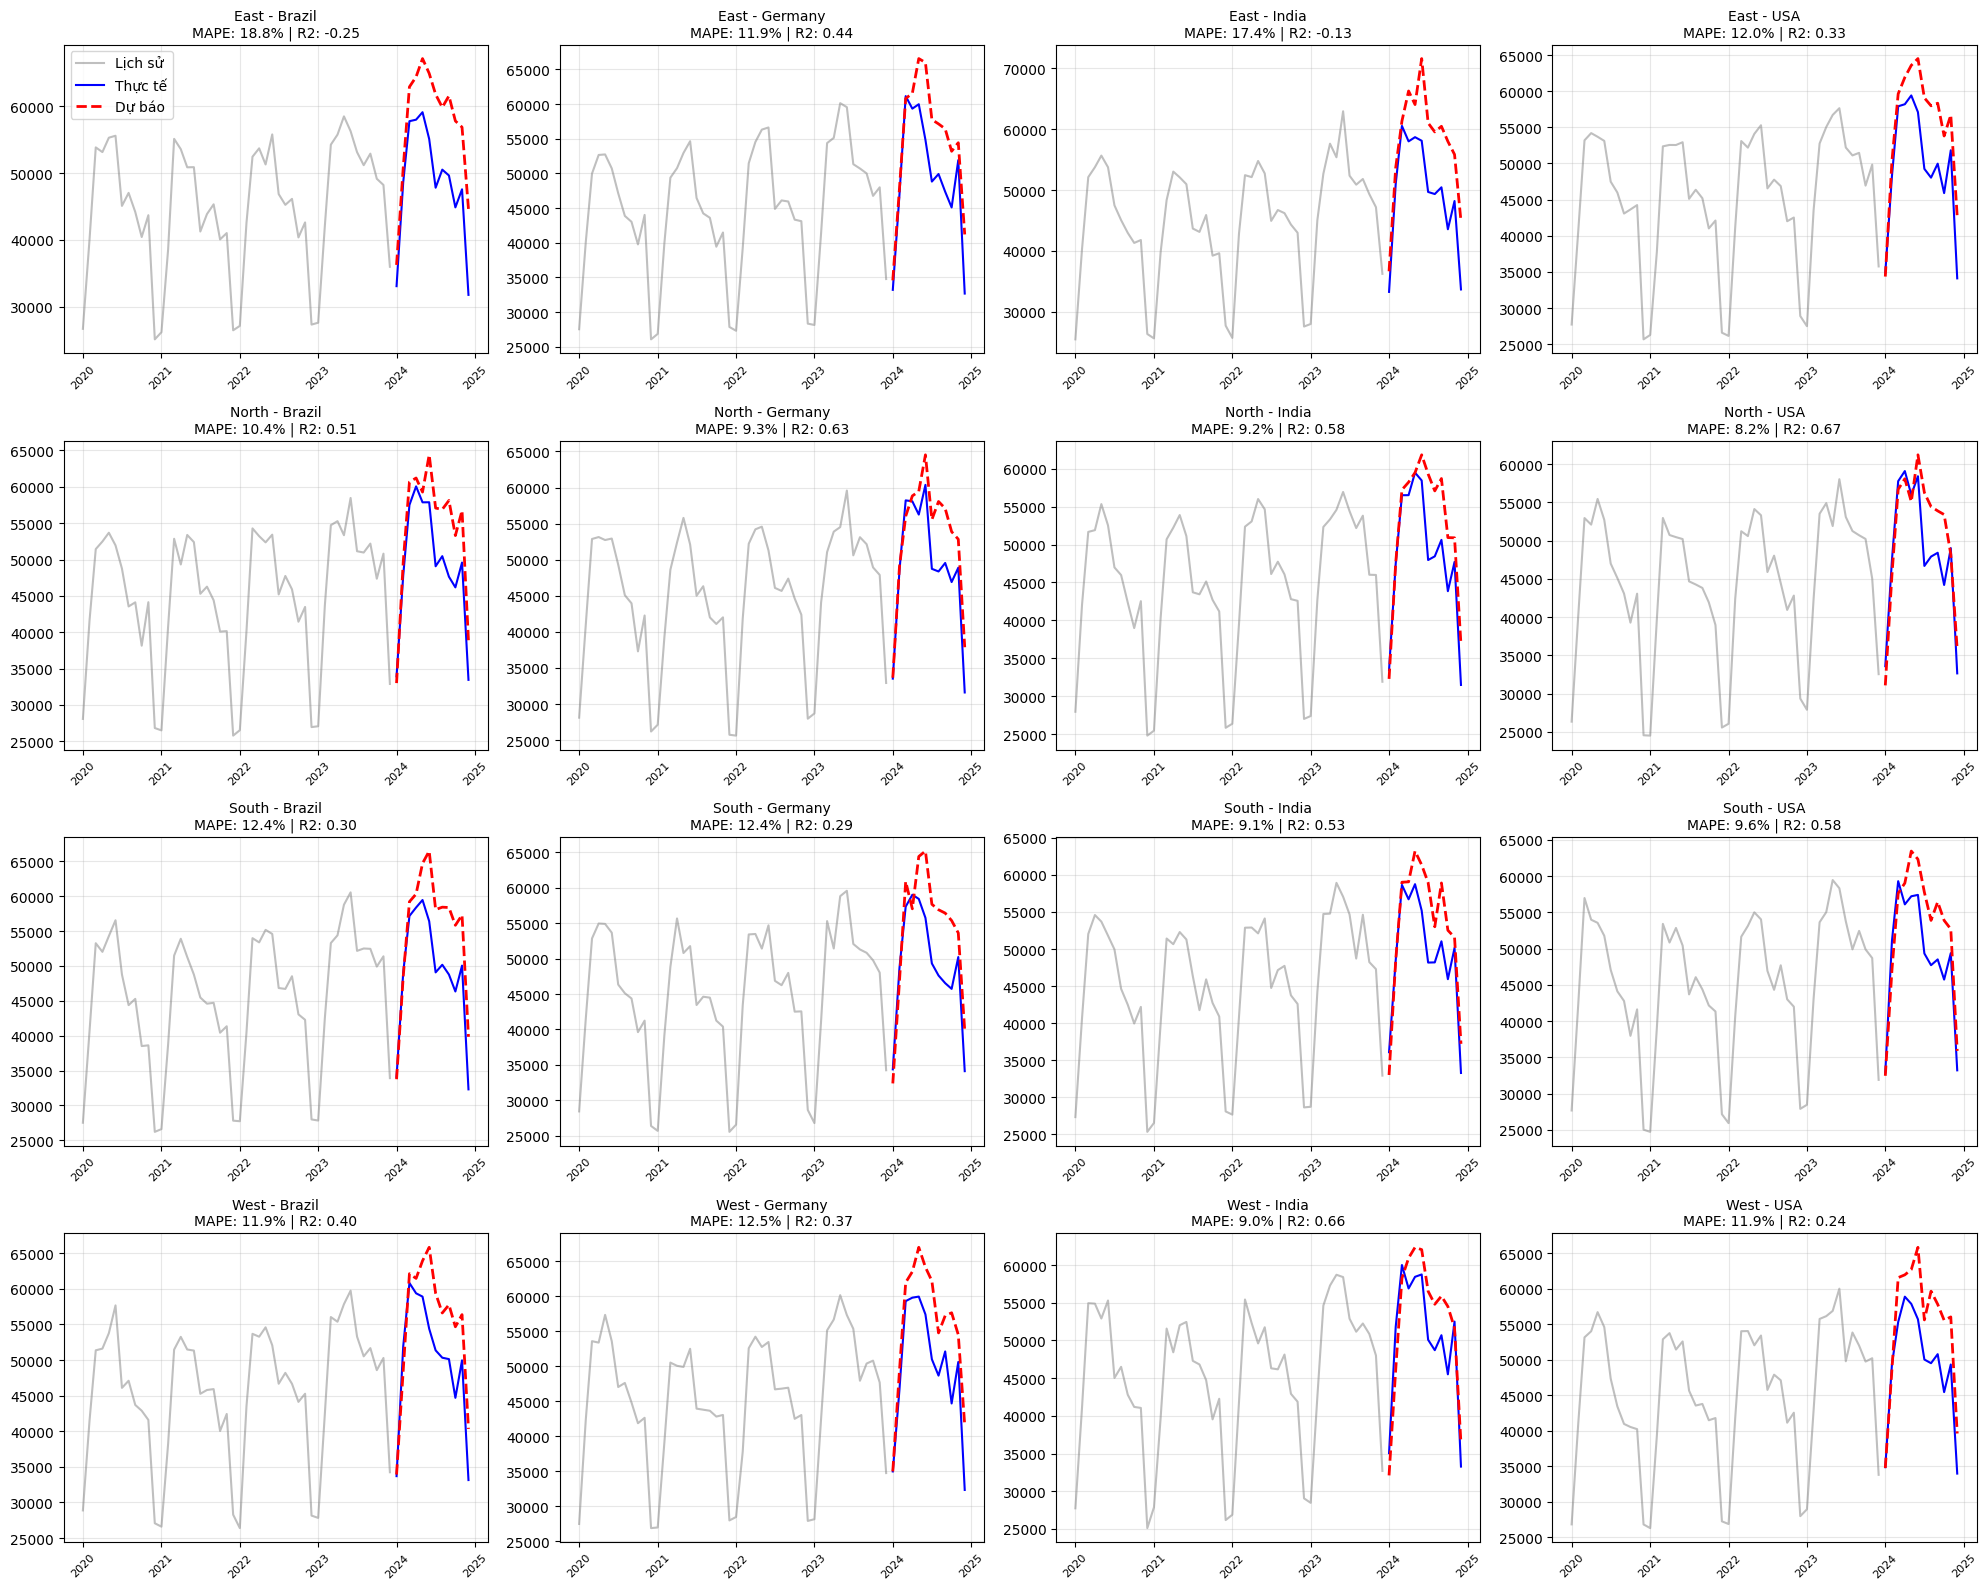

In [ ]:
# 1. In Báo cáo Tổng hợp trước
results_df = pd.DataFrame(metrics)

print("="*40)
print("KẾT QUẢ HIỆU SUẤT TRUNG BÌNH (TOÀN CỤC)")
print("="*40)
print(results_df[['MAPE (%)', 'RMSE', 'MAE', 'R2 Score']].mean())

print("\n" + "="*40)
print("TOP 5 THỊ TRƯỜNG TỐT NHẤT (MAPE THẤP NHẤT)")
print(results_df.sort_values('MAPE (%)').head(5)[['Region', 'Country', 'MAPE (%)', 'R2 Score']])

# 2. Vẽ biểu đồ Grid Layout
valid_pairs = list(forecast_results.keys()) # Chỉ lấy những cặp đã chạy thành công
n_charts = len(valid_pairs)
n_cols = 4
n_rows = math.ceil(n_charts / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

print(f"\n--- Đang vẽ {n_charts} biểu đồ ---")

for i, (region, country) in enumerate(valid_pairs):
    ax = axes[i]
    data = forecast_results[(region, country)]

    # Lấy dữ liệu đã lưu
    train = data['train']
    test = data['test']
    preds = data['preds']
    mape = data['mape']
    r2 = data['r2']

    # Vẽ
    ax.plot(train.index, train, label='Lịch sử', color='gray', alpha=0.5)
    ax.plot(test.index, test, label='Thực tế', color='blue')
    ax.plot(preds.index, preds, label='Dự báo', color='red', linestyle='--', linewidth=2)

    # Trang trí
    ax.set_title(f"{region} - {country}\nMAPE: {mape:.1f}% | R2: {r2:.2f}", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3)

    if i == 0: ax.legend(loc='upper left')

# Xóa khung hình dư thừa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### HOLT-WINTERS

1. THỰC HIỆN (CHIA TRAIN/TEST, HUẤN LUYỆN, DỰ BÁO VÀ ĐÁNH GIÁ)

In [ ]:
pairs = df_master[['region', 'country']].drop_duplicates().values.tolist()

metrics = []
forecast_results = {} # Biến lưu kết quả để vẽ ở Cell sau

print(f"--- Bắt đầu chạy HOLT-WINTERS cho {len(pairs)} thị trường ---")

for i, (region, country) in enumerate(pairs):
    print(f"[{i+1}/{len(pairs)}] {region} - {country}...", end=" ")

    # Lấy dữ liệu
    subset = df_master[(df_master['region'] == region) & (df_master['country'] == country)]
    ts_data = subset.set_index('date').asfreq('MS')['units_sold'].fillna(0)

    # Kiểm tra độ dài (Holt-Winters cần ít nhất 2 chu kỳ mùa vụ = 24 tháng)
    if len(ts_data) < 24:
        print("-> SKIP (Ít dữ liệu)")
        continue

    # Chia Train/Test
    test_len = 12
    train = ts_data.iloc[:-test_len]
    test = ts_data.iloc[-test_len:]

    try:
        # --- CẤU HÌNH HOLT-WINTERS ---
        # trend='add': Xu hướng tăng/giảm tuyến tính (dùng 'add' vì có số 0)
        # seasonal='add': Mùa vụ cộng (dùng 'add' vì có số 0)
        # seasonal_periods=12: Chu kỳ 12 tháng
        model = ExponentialSmoothing(train,
                                     trend='add',
                                     seasonal='add',
                                     seasonal_periods=12).fit()

        # Dự báo
        preds = model.forecast(steps=test_len)

        # Tính toán chỉ số
        mape = mean_absolute_percentage_error(test, preds) * 100
        rmse = np.sqrt(mean_squared_error(test, preds))
        mae = mean_absolute_error(test, preds)
        r2 = r2_score(test, preds)

        # Lưu kết quả số
        metrics.append({
            'Region': region,
            'Country': country,
            'MAPE (%)': mape,
            'RMSE': rmse,
            'MAE': mae,
            'R2 Score': r2
        })

        # Lưu dữ liệu chuỗi để vẽ
        forecast_results[(region, country)] = {
            'train': train,
            'test': test,
            'preds': preds,
            'mape': mape,
            'r2': r2
        }
        print("-> Xong.")

    except Exception as e:
        print(f"-> Lỗi: {e}")


--- Bắt đầu chạy HOLT-WINTERS cho 16 thị trường ---
[1/16] East - Brazil... -> Xong.
[2/16] East - Germany... -> Xong.
[3/16] East - India... -> Xong.
[4/16] East - USA... -> Xong.
[5/16] North - Brazil... -> Xong.
[6/16] North - Germany... -> Xong.
[7/16] North - India... -> Xong.
[8/16] North - USA... -> Xong.
[9/16] South - Brazil... -> Xong.
[10/16] South - Germany... -> Xong.
[11/16] South - India... -> Xong.
[12/16] South - USA... -> Xong.
[13/16] West - Brazil... -> Xong.
[14/16] West - Germany... -> Xong.
[15/16] West - India... -> Xong.
[16/16] West - USA... -> Xong.


2. KẾT QUẢ

KẾT QUẢ ĐÁNH GIÁ HOLT-WINTERS (TRUNG BÌNH)
MAPE (%)      10.009185
RMSE        5497.127542
MAE         4777.064856
R2 Score       0.522458
dtype: float64

TOP 5 THỊ TRƯỜNG DỰ BÁO CHÍNH XÁC NHẤT
   Region Country  MAPE (%)  R2 Score
6   North   India  4.108683  0.918849
11  South     USA  5.182897  0.861204
14   West   India  5.589929  0.857904
15   West     USA  6.867780  0.722801
8   South  Brazil  8.009420  0.717375

--- Đang vẽ 16 biểu đồ Holt-Winters ---


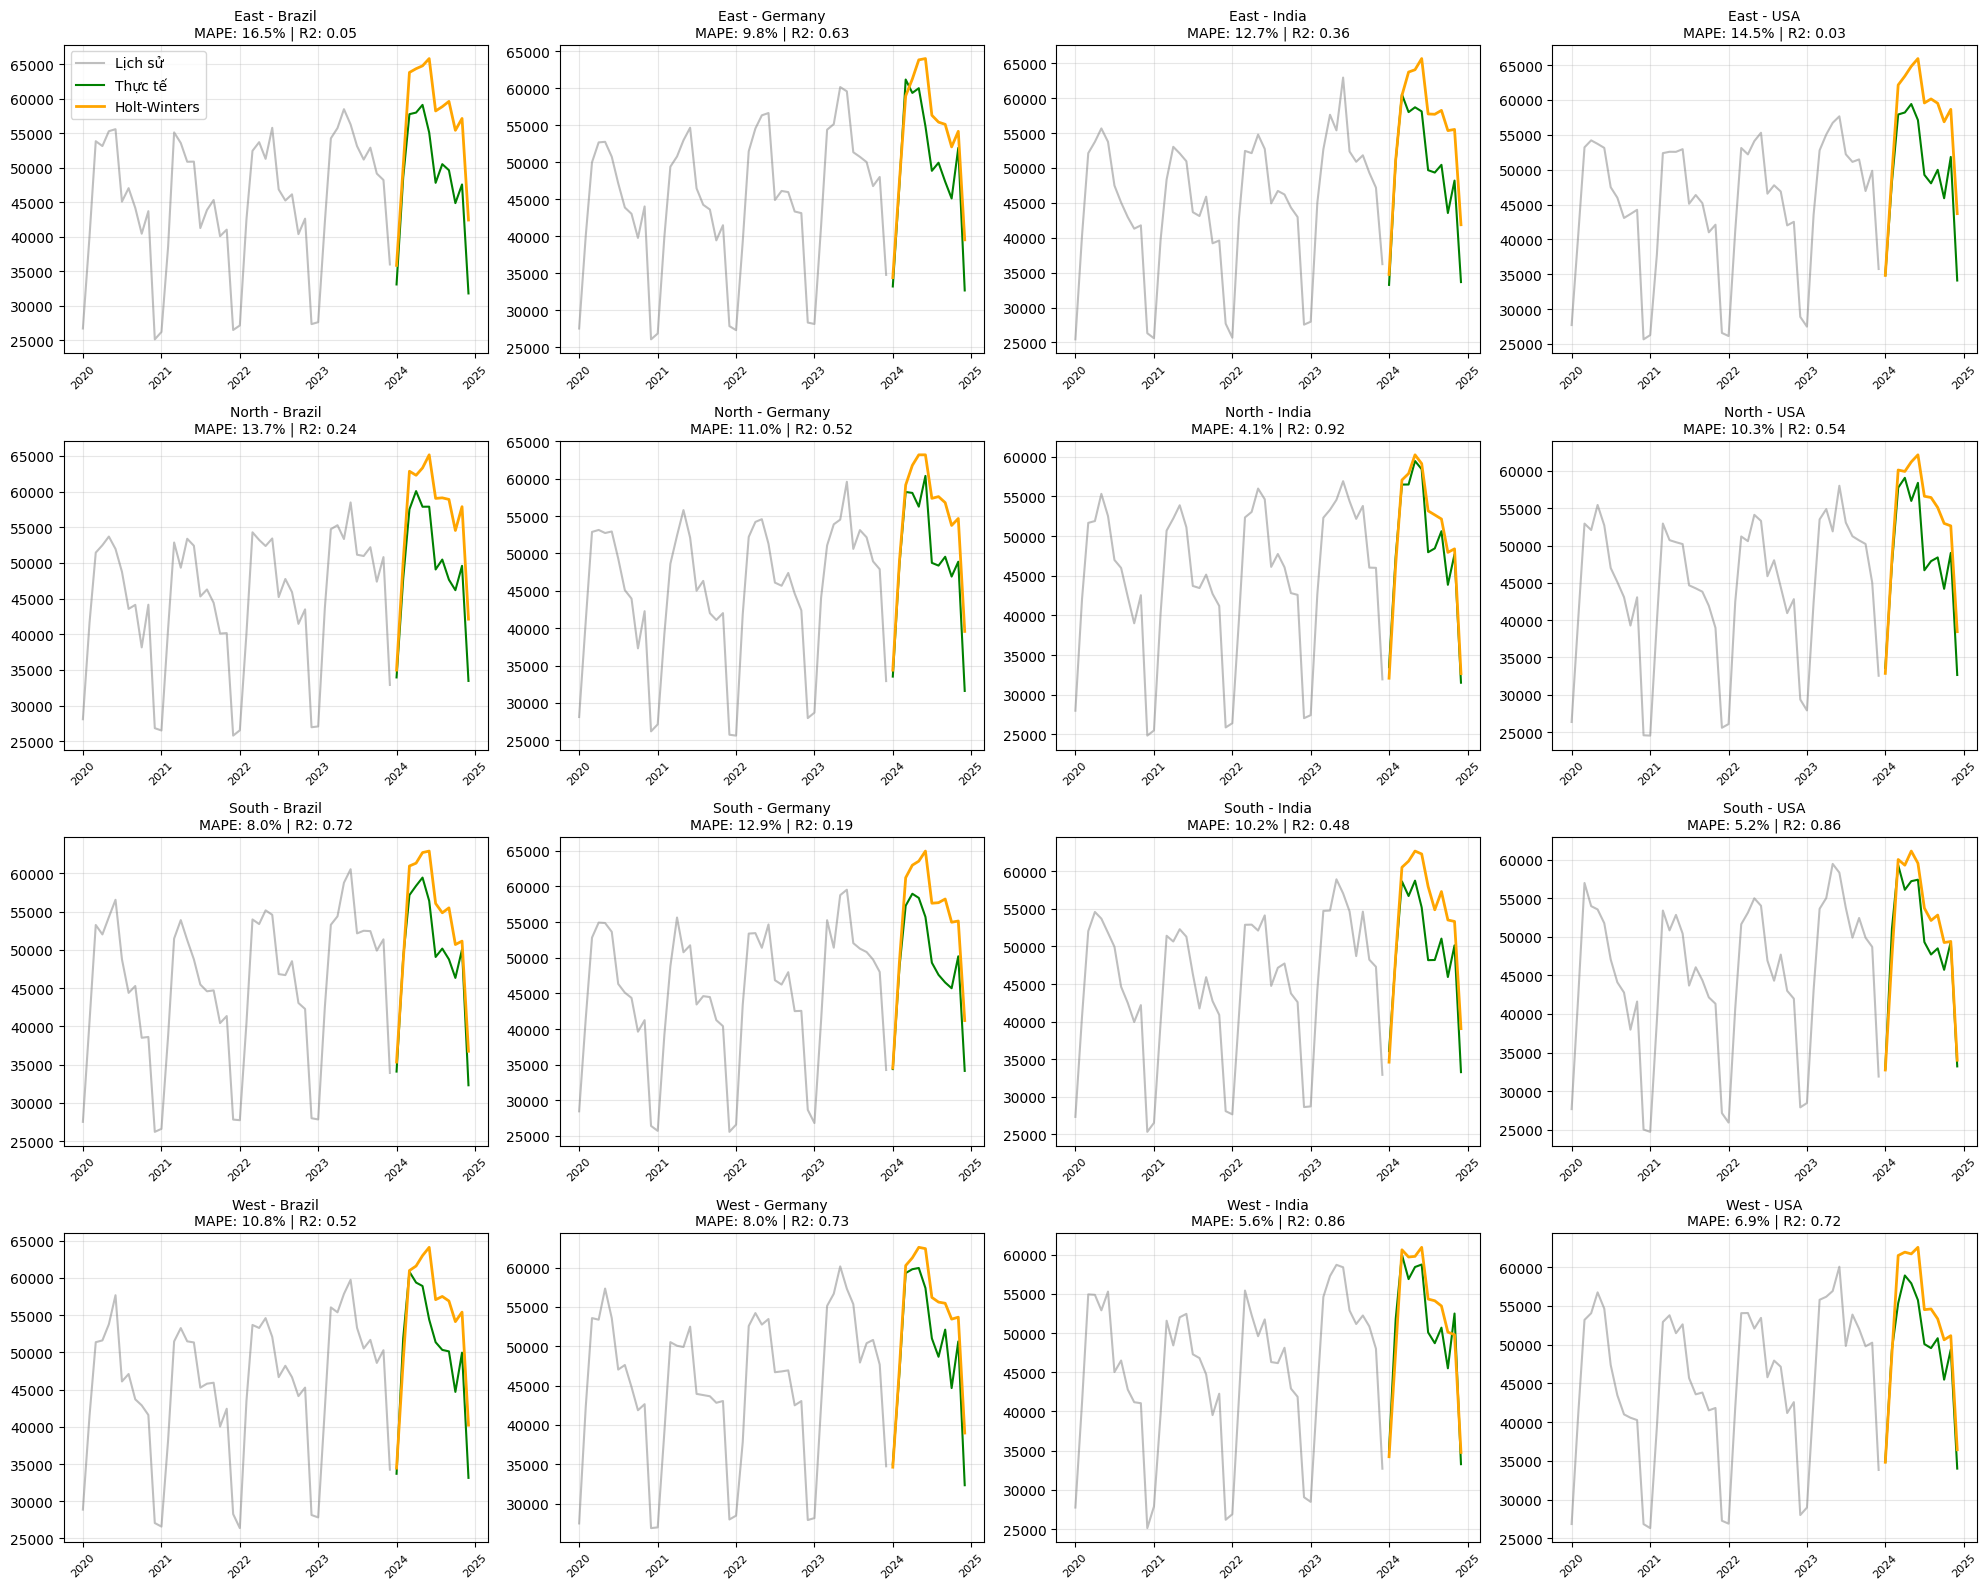

In [ ]:
# 1. In Báo cáo Tổng hợp
results_df = pd.DataFrame(metrics)

print("="*40)
print("KẾT QUẢ ĐÁNH GIÁ HOLT-WINTERS (TRUNG BÌNH)")
print("="*40)
# Tính trung bình và hiển thị
print(results_df[['MAPE (%)', 'RMSE', 'MAE', 'R2 Score']].mean())

print("\n" + "="*40)
print("TOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT")
print(results_df.sort_values('MAPE (%)').head(5)[['Region', 'Country', 'MAPE (%)', 'R2 Score']])

# 2. Vẽ biểu đồ Grid Layout
valid_pairs = list(forecast_results.keys())
n_charts = len(valid_pairs)
n_cols = 4
n_rows = math.ceil(n_charts / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

print(f"\n--- Đang vẽ {n_charts} biểu đồ Holt-Winters ---")

for i, (region, country) in enumerate(valid_pairs):
    ax = axes[i]
    data = forecast_results[(region, country)]

    # Lấy dữ liệu
    train = data['train']
    test = data['test']
    preds = data['preds']
    mape = data['mape']
    r2 = data['r2']

    # Vẽ
    ax.plot(train.index, train, label='Lịch sử', color='gray', alpha=0.5)
    ax.plot(test.index, test, label='Thực tế', color='green') # Đổi màu xanh lá cho khác biệt
    ax.plot(preds.index, preds, label='Holt-Winters', color='orange', linestyle='-', linewidth=2)

    # Trang trí
    ax.set_title(f"{region} - {country}\nMAPE: {mape:.1f}% | R2: {r2:.2f}", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3)

    if i == 0: ax.legend(loc='upper left')

# Xóa khung hình dư thừa
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### XGBOOST

1. TẠO BIẾN ĐẶC TRƯNG (FEATURE ENGINEERING)

In [ ]:
from sklearn.preprocessing import LabelEncoder
df_ml = df_master.copy()

# 2.1. Mã hóa Region và Country thành số (Máy tính mới hiểu được)
le_region = LabelEncoder()
le_country = LabelEncoder()
df_ml['region_code'] = le_region.fit_transform(df_ml['region'])
df_ml['country_code'] = le_country.fit_transform(df_ml['country'])

# 2.2. Tạo đặc trưng thời gian (Time Features)
df_ml['month'] = df_ml['date'].dt.month
df_ml['year'] = df_ml['date'].dt.year
df_ml['quarter'] = df_ml['date'].dt.quarter

# 2.3. Tạo đặc trưng độ trễ (Lag Features) - "Quá khứ dự báo tương lai"
# Lưu ý: Phải groupby trước khi shift để không bị lẫn số liệu giữa các nước
df_ml['lag_1'] = df_ml.groupby(['region', 'country'])['units_sold'].shift(1)  # Doanh số tháng trước
df_ml['lag_3'] = df_ml.groupby(['region', 'country'])['units_sold'].shift(3)  # Doanh số quý trước
df_ml['lag_12'] = df_ml.groupby(['region', 'country'])['units_sold'].shift(12) # Doanh số cùng kỳ năm ngoái (Mùa vụ)

# Xóa các dòng bị NaN do tạo Lag (12 tháng đầu sẽ mất)
df_ml = df_ml.dropna()

# Tổng hợp tất cả features đầu vào (X)
features = ['region_code', 'country_code',   # Địa lý
            'month', 'year', 'quarter',      # Thời gian
            'lag_1', 'lag_3', 'lag_12'] +   exog_cols

target = 'units_sold'

2. CHIA TRAIN / TEST

In [ ]:
test_months = 12
split_date = df_ml['date'].max() - pd.DateOffset(months=test_months-1)

train_data = df_ml[df_ml['date'] < split_date]
test_data = df_ml[df_ml['date'] >= split_date]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

3. HUẤN LUYỆN XGBOOST

In [ ]:
print(f"--- Đang huấn luyện XGBoost với {len(features)} biến đầu vào... ---")
# Các biến đầu vào gồm: {features}

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)



--- Đang huấn luyện XGBoost với 14 biến đầu vào... ---


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

4. DỰ BÁO VÀ ĐÁNH GIÁ

--- Đang tính toán lại các chỉ số đánh giá (Metrics)... ---

KẾT QUẢ TRUNG BÌNH XGBOOST (TOÀN CỤC)
MAPE (%)       7.118957
RMSE        3657.509961
MAE         3203.335342
R2 Score       0.807182
dtype: float64

TOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT (THEO MAPE)
   Region  Country  MAPE (%)  R2 Score         RMSE
15   West      USA  6.236340  0.823247  3218.996427
3    East      USA  6.547383  0.818995  3420.756203
8   South   Brazil  6.697235  0.837638  3346.882579
0    East   Brazil  6.749494  0.840631  3399.515260
5   North  Germany  6.885248  0.844787  3406.105107

--- Đang vẽ 16 biểu đồ dự báo ---


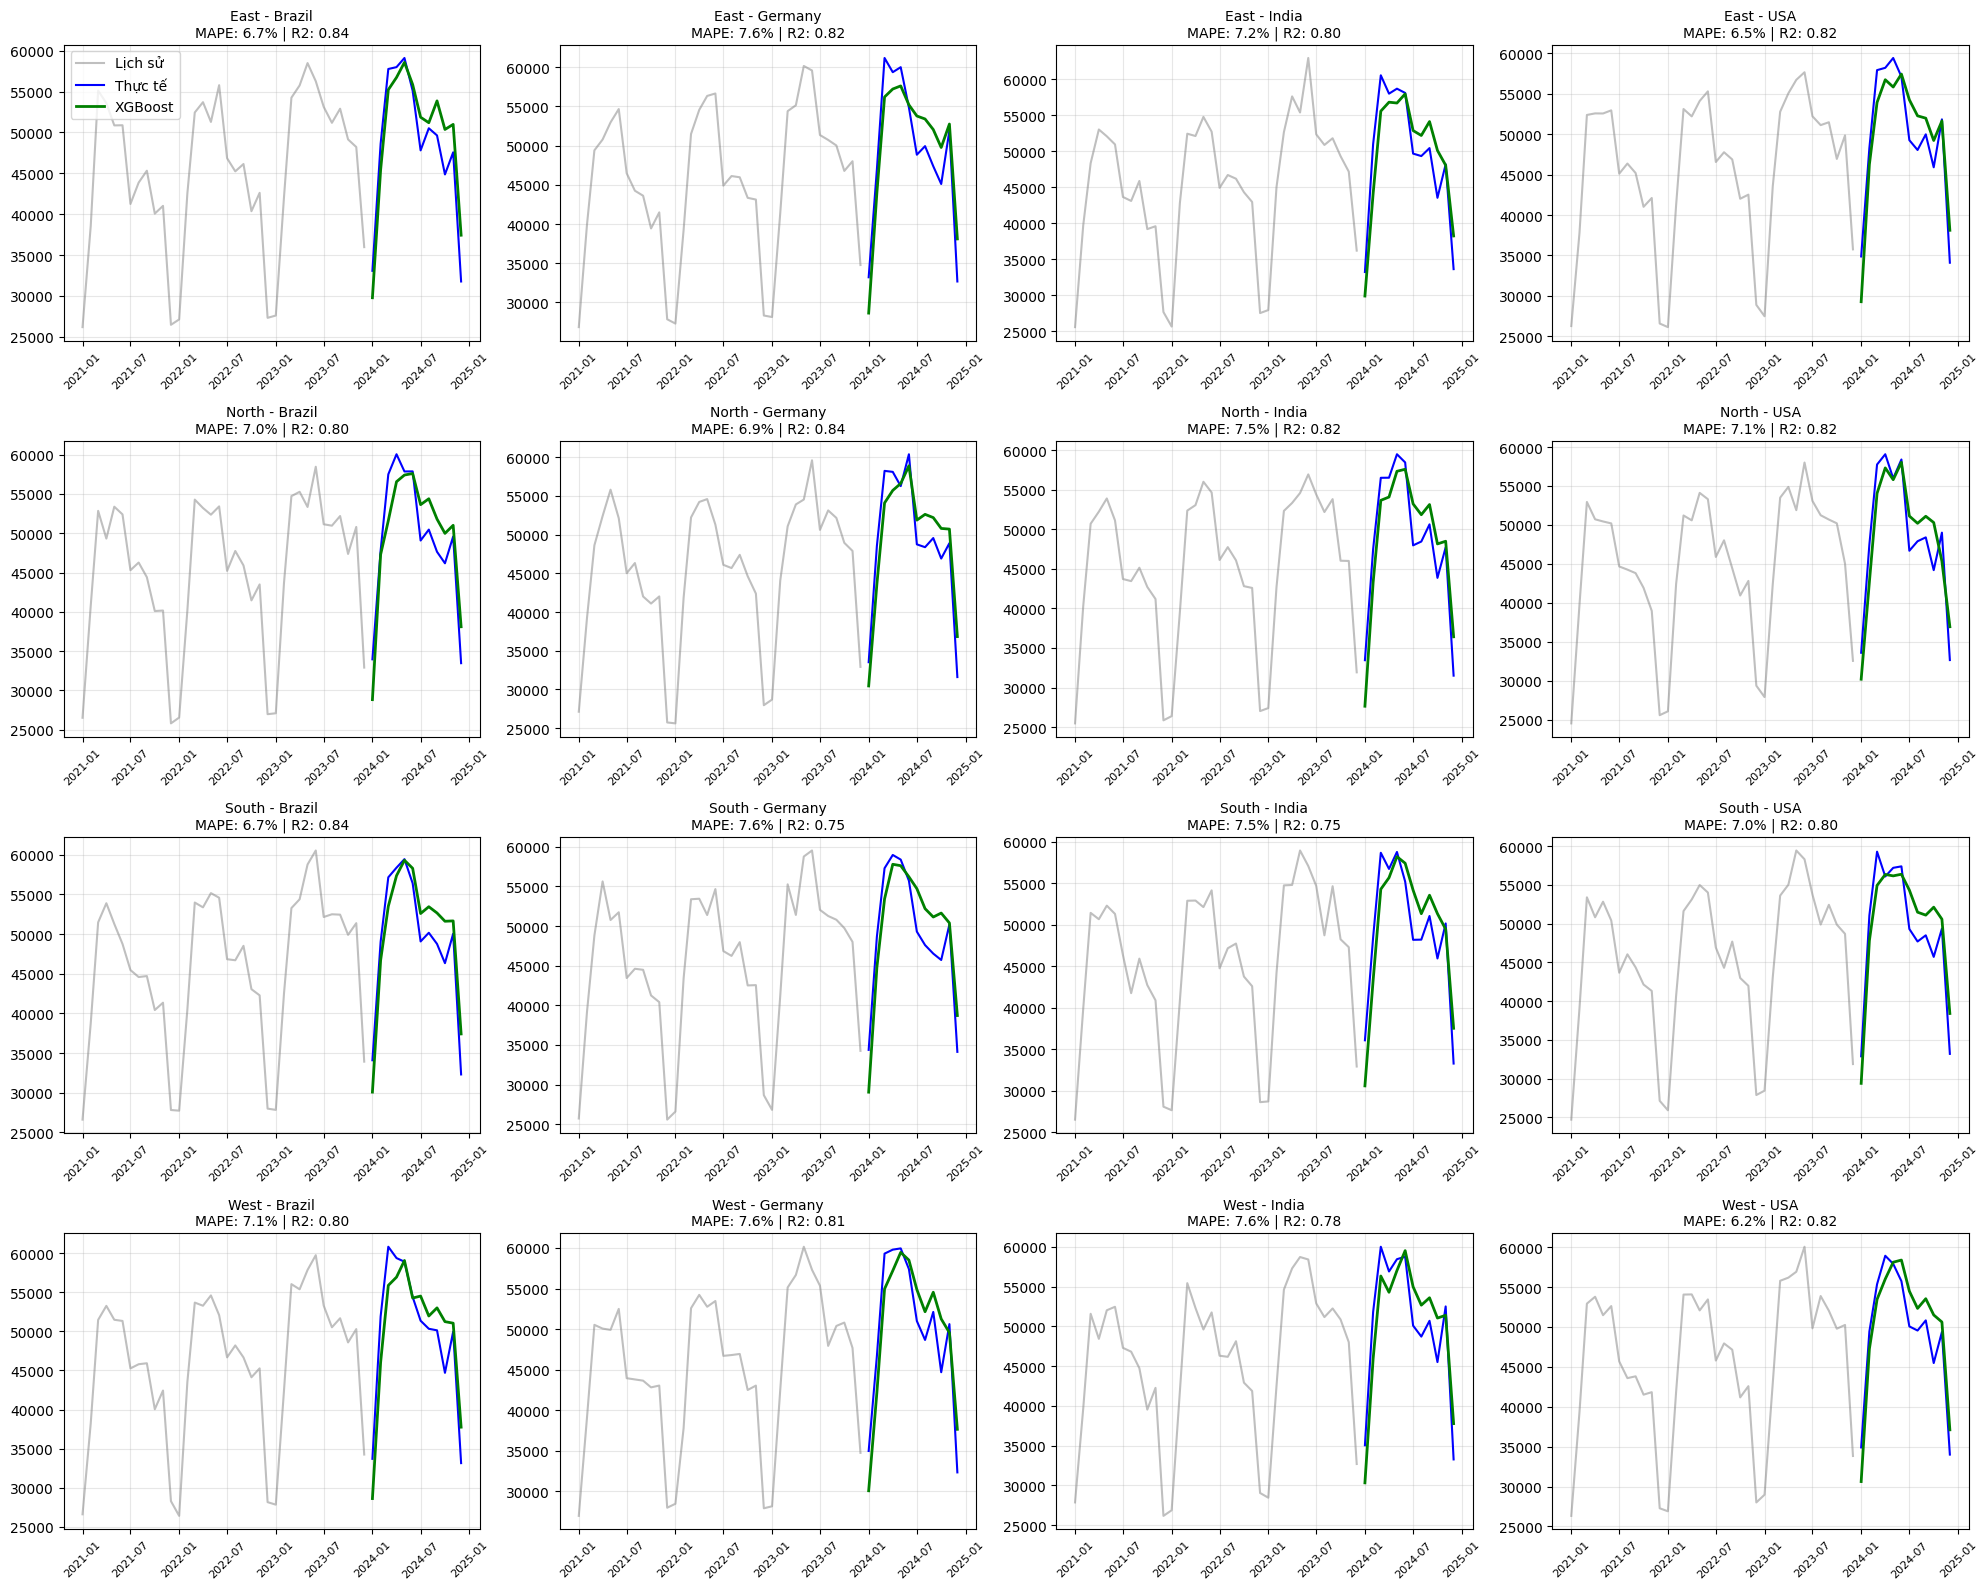

<Figure size 1000x600 with 0 Axes>

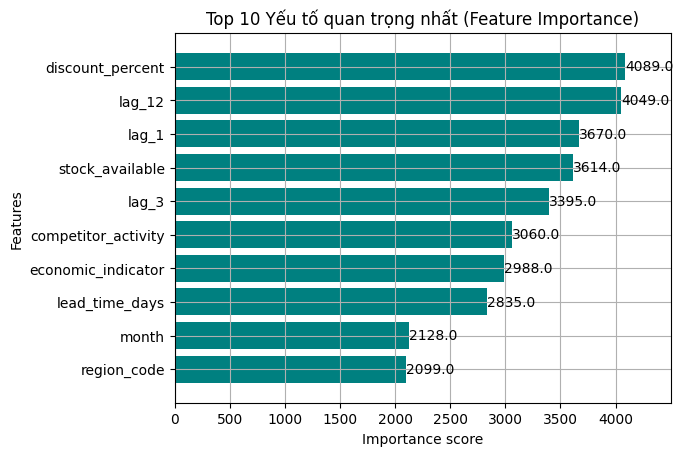

In [ ]:
# Dự báo toàn bộ tập Test
test_data['prediction'] = model.predict(X_test)

metrics = []
forecast_results = {}
pairs = df_ml[['region', 'country']].drop_duplicates().values.tolist()

print("--- Đang tính toán lại các chỉ số đánh giá (Metrics)... ---")

for region, country in pairs:
    # Lấy tập test và train riêng cho quốc gia này
    subset_test = test_data[(test_data['region'] == region) & (test_data['country'] == country)]
    subset_train = train_data[(train_data['region'] == region) & (train_data['country'] == country)]

    if len(subset_test) == 0: continue

    # Chuẩn hóa Index về dạng Datetime để vẽ không bị lỗi
    y_true = subset_test.set_index('date')['units_sold']
    y_pred = subset_test.set_index('date')['prediction']
    y_train = subset_train.set_index('date')['units_sold']

    # --- TÍNH TOÁN ĐẦY ĐỦ 4 CHỈ SỐ ---
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics.append({
        'Region': region,
        'Country': country,
        'MAPE (%)': mape,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

    # Lưu lại dữ liệu để vẽ biểu đồ
    forecast_results[(region, country)] = {
        'train': y_train,
        'test': y_true,
        'preds': y_pred,
        'mape': mape,
        'r2': r2
    }

# --- 1. Hiển thị Bảng Tổng hợp ---
results_df = pd.DataFrame(metrics)

print("\n" + "="*50)
print("KẾT QUẢ TRUNG BÌNH XGBOOST (TOÀN CỤC)")
print("="*50)
# In trung bình các cột số
print(results_df[['MAPE (%)', 'RMSE', 'MAE', 'R2 Score']].mean())

print("\n" + "="*50)
print("TOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT (THEO MAPE)")
print("="*50)
# Sắp xếp theo MAPE tăng dần (càng nhỏ càng tốt)
print(results_df.sort_values('MAPE (%)').head(5)[['Region', 'Country', 'MAPE (%)', 'R2 Score', 'RMSE']])

# --- 2. Vẽ biểu đồ Grid ---
valid_pairs = list(forecast_results.keys())
n_charts = len(valid_pairs)
n_cols = 4
n_rows = math.ceil(n_charts / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

print(f"\n--- Đang vẽ {n_charts} biểu đồ dự báo ---")

for i, (region, country) in enumerate(valid_pairs):
    ax = axes[i]
    data = forecast_results[(region, country)]

    # Vẽ các đường
    ax.plot(data['train'].index, data['train'], label='Lịch sử', color='gray', alpha=0.5)
    ax.plot(data['test'].index, data['test'], label='Thực tế', color='blue')
    ax.plot(data['preds'].index, data['preds'], label='XGBoost', color='green', linestyle='-', linewidth=2)

    ax.set_title(f"{region} - {country}\nMAPE: {data['mape']:.1f}% | R2: {data['r2']:.2f}", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3)

    if i == 0: ax.legend(loc='upper left')

# Xóa các khung hình dư
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# --- 3. Vẽ Feature Importance ---
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, height=0.8,
                    title='Top 10 Yếu tố quan trọng nhất (Feature Importance)',
                    color='teal', importance_type='weight')
plt.show()

#### PROPHET

1. THỰC HIỆN (CHIA TRAIN/TEST, HUẤN LUYỆN, DỰ BÁO VÀ ĐÁNH GIÁ)

In [ ]:
pairs = df_master[['region', 'country']].drop_duplicates().values.tolist()
metrics = []
forecast_results = {}

print(f"--- Bắt đầu chạy Prophet (Logistic - Tinh chỉnh) cho {len(pairs)} thị trường ---")

for i, (region, country) in enumerate(pairs):
    print(f"[{i+1}/{len(pairs)}] {region} - {country}...", end=" ")

    subset = df_master[(df_master['region'] == region) & (df_master['country'] == country)]
    df_prophet = subset.rename(columns={'date': 'ds', 'units_sold': 'y'})

    if len(df_prophet) < 24:
        print("-> SKIP (Ít dữ liệu)")
        continue

    # --- TỐI ƯU 1: ĐIỀU CHỈNH CAP (NGƯỠNG TRẦN) ---
    # Thay vì nhân 1.1, ta chỉ nhân 1.02 (tăng nhẹ 2%) hoặc giữ nguyên max lịch sử
    # Điều này giúp kìm hãm mô hình không phóng đại xu hướng tăng
    max_historic_sales = df_prophet['y'].max()
    cap_value = max_historic_sales * 1.02 # <--- GIẢM TỪ 1.1 XUỐNG 1.02

    df_prophet['cap'] = cap_value
    df_prophet['floor'] = 0 # Hoặc có thể thử đặt floor cao hơn 0 một chút (vd: min_sales * 0.5)

    test_len = 12
    train_df = df_prophet.iloc[:-test_len]
    test_df = df_prophet.iloc[-test_len:]

    try:
        model = Prophet(
            growth='logistic',
            seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            # --- TỐI ƯU 2: SIẾT CHẶT TREND ---
            changepoint_prior_scale=0.01,
            seasonality_prior_scale=10.0,
            interval_width=0.95
        )

        for reg in exog_cols:
            model.add_regressor(reg)

        model.fit(train_df)
        forecast = model.predict(test_df)

        y_pred = forecast['yhat'].values
        y_pred = np.maximum(y_pred, 0)
        y_true = test_df['y'].values

        # Đánh giá
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        metrics.append({
            'Region': region, 'Country': country,
            'MAPE (%)': mape, 'RMSE': rmse, 'MAE': mae, 'R2 Score': r2
        })

        forecast_results[(region, country)] = {
            'train': train_df.set_index('ds')['y'],
            'test': test_df.set_index('ds')['y'],
            'preds': pd.Series(y_pred, index=test_df['ds']),
            'mape': mape, 'r2': r2, 'cap': cap_value
        }
        print("-> Xong.")

    except Exception as e:
        print(f"-> Lỗi: {e}")

--- Bắt đầu chạy Prophet (Logistic - Tinh chỉnh) cho 16 thị trường ---
[1/16] East - Brazil... -> Xong.
[2/16] East - Germany... -> Xong.
[3/16] East - India... -> Xong.
[4/16] East - USA... -> Xong.
[5/16] North - Brazil... -> Xong.
[6/16] North - Germany... -> Xong.
[7/16] North - India... -> Xong.
[8/16] North - USA... -> Xong.
[9/16] South - Brazil... -> Xong.
[10/16] South - Germany... -> Xong.
[11/16] South - India... -> Xong.
[12/16] South - USA... -> Xong.
[13/16] West - Brazil... -> Xong.
[14/16] West - Germany... -> Xong.
[15/16] West - India... -> Xong.
[16/16] West - USA... -> Xong.


2. KẾT QUẢ


KẾT QUẢ TRUNG BÌNH PROPHET (CẤU HÌNH CỦA BẠN)
MAPE (%)       4.994699
RMSE        2814.556384
MAE         2238.363030
R2 Score       0.882983
dtype: float64

TOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT
   Region  Country  MAPE (%)  R2 Score
5   North  Germany  3.772327  0.913752
11  South      USA  4.022988  0.936831
6   North    India  4.398853  0.927364
9   South  Germany  4.477670  0.879760
1    East  Germany  4.531677  0.926218

--- Đang vẽ biểu đồ ---


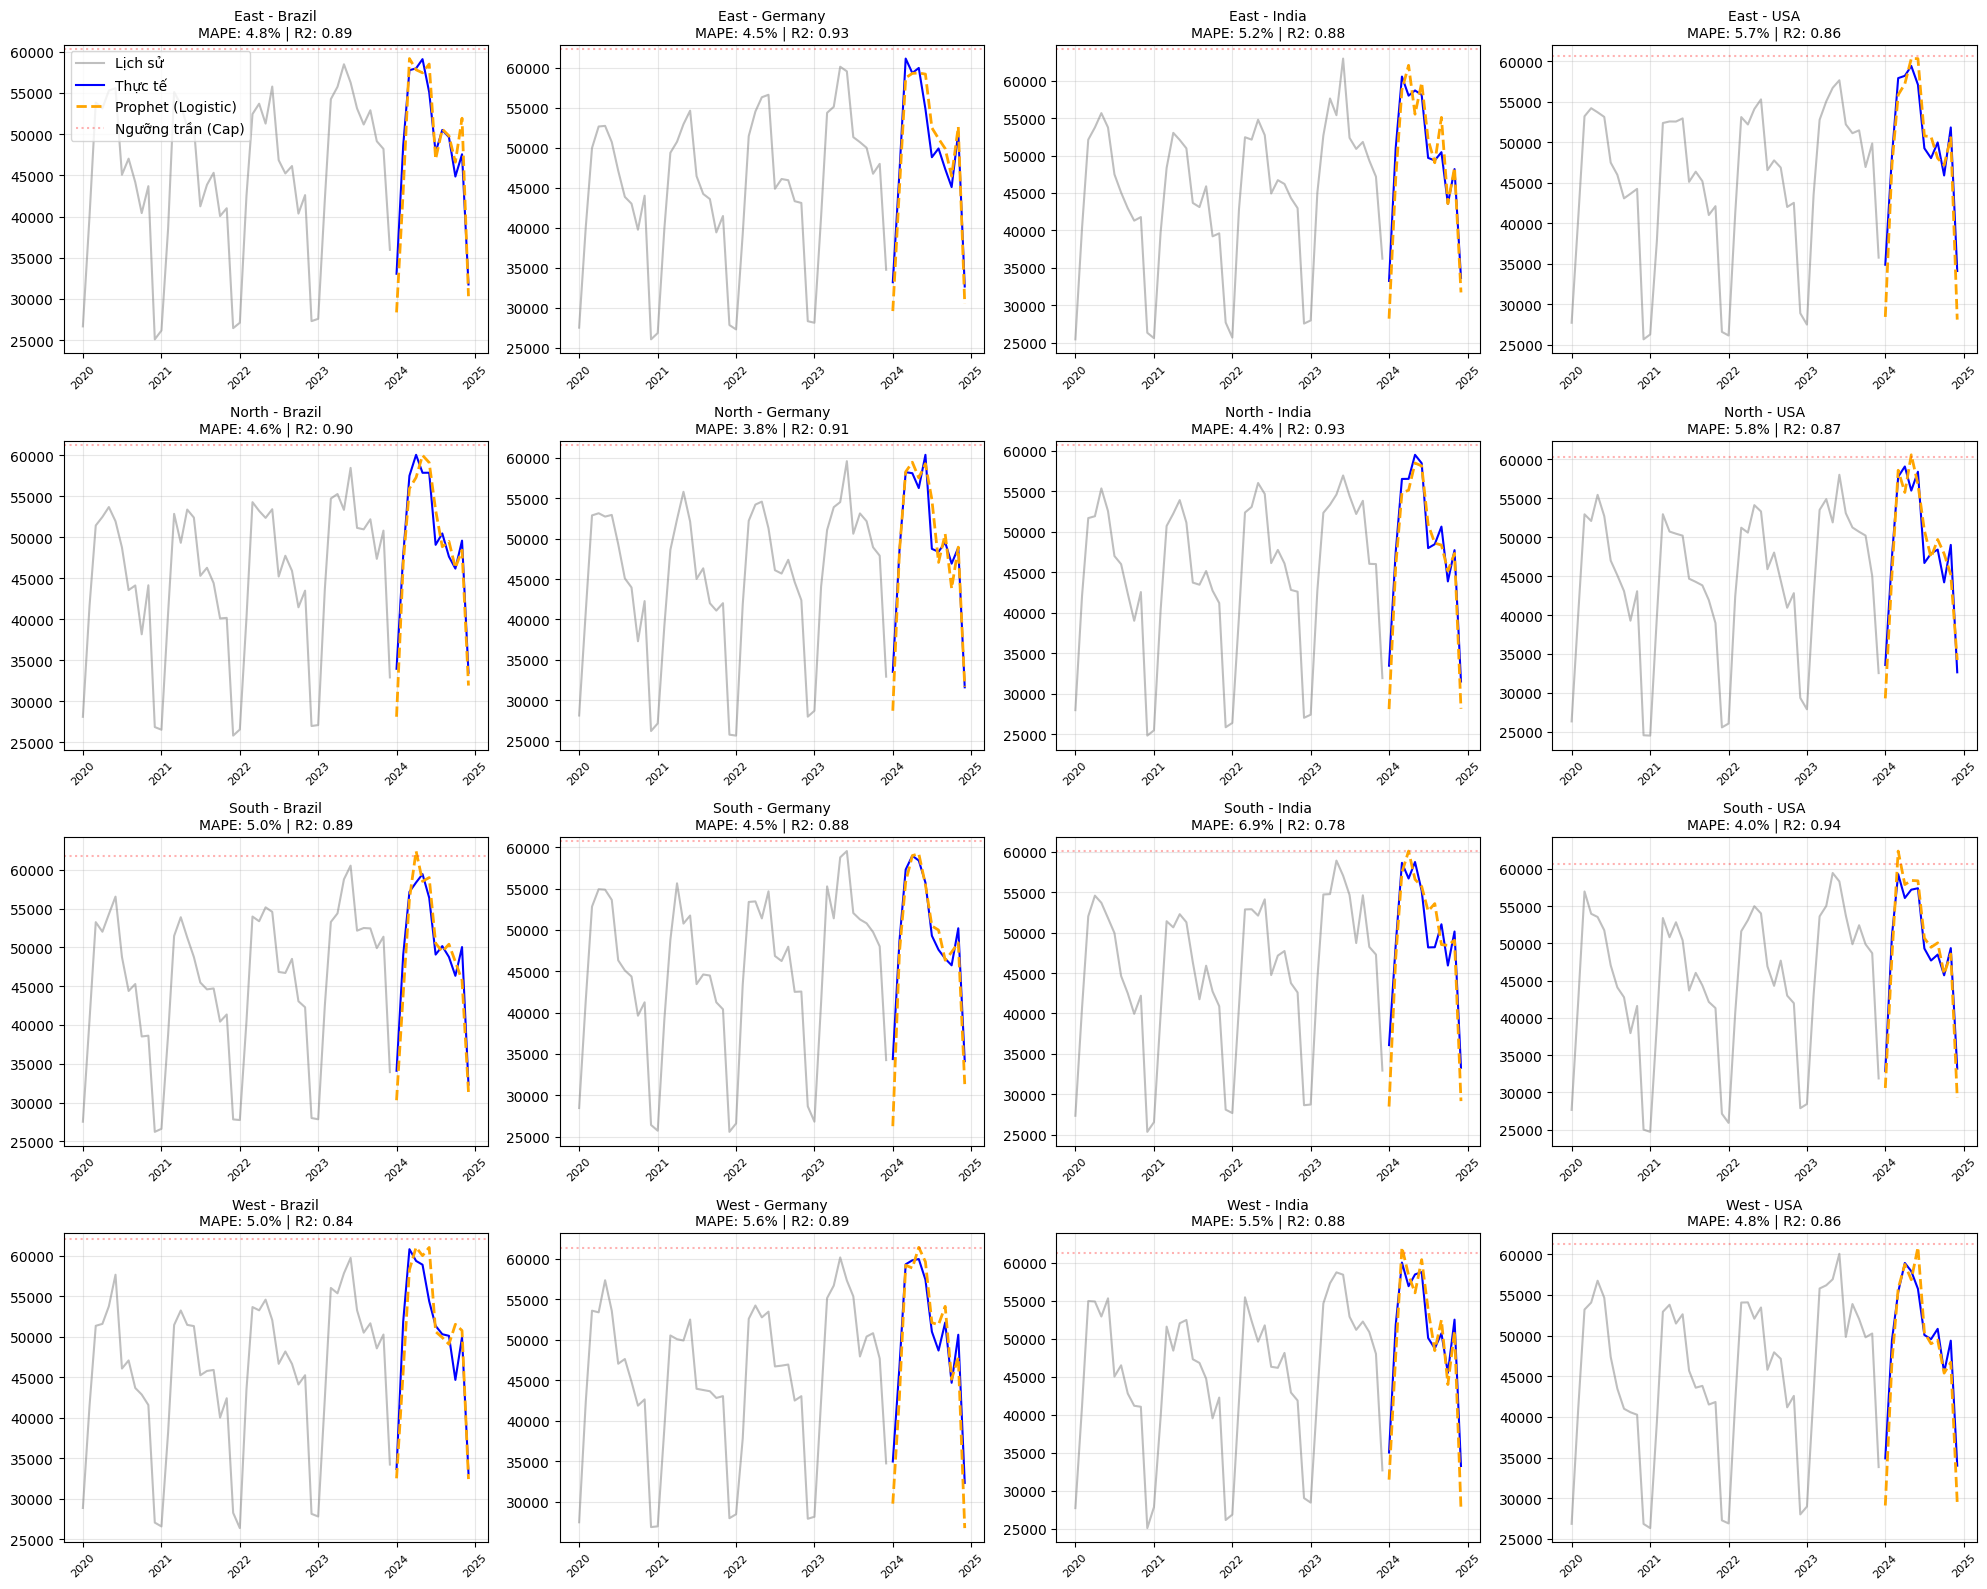

In [ ]:
# 1. Bảng Tổng hợp
results_df = pd.DataFrame(metrics)

print("\n" + "="*50)
print("KẾT QUẢ TRUNG BÌNH PROPHET (CẤU HÌNH CỦA BẠN)")
print("="*50)
print(results_df[['MAPE (%)', 'RMSE', 'MAE', 'R2 Score']].mean())

print("\n" + "="*50)
print("TOP 5 THỊ TRƯỜNG DỰ BÁO TỐT NHẤT")
print("="*50)
print(results_df.sort_values('MAPE (%)').head(5)[['Region', 'Country', 'MAPE (%)', 'R2 Score']])

# 2. Vẽ biểu đồ Grid
valid_pairs = list(forecast_results.keys())
n_charts = len(valid_pairs)
n_cols = 4
n_rows = math.ceil(n_charts / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

print(f"\n--- Đang vẽ biểu đồ ---")

for i, (region, country) in enumerate(valid_pairs):
    ax = axes[i]
    data = forecast_results[(region, country)]

    # Vẽ
    ax.plot(data['train'].index, data['train'], label='Lịch sử', color='gray', alpha=0.5)
    ax.plot(data['test'].index, data['test'], label='Thực tế', color='blue')
    ax.plot(data['preds'].index, data['preds'], label='Prophet (Logistic)', color='orange', linestyle='--', linewidth=2)

    # Vẽ đường trần (Cap) mờ mờ để thầy thấy ta dùng Logistic growth
    ax.axhline(y=data['cap'], color='red', linestyle=':', alpha=0.3, label='Ngưỡng trần (Cap)')

    ax.set_title(f"{region} - {country}\nMAPE: {data['mape']:.1f}% | R2: {data['r2']:.2f}", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.grid(True, alpha=0.3)

    if i == 0: ax.legend(loc='upper left')

# Xóa khung hình dư
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()